# TP3

In [1]:
#Importamos librerias de interes (no hace falta utilizar todas)
import pandas as pd
import pickle
import spacy
import numpy as np
import os
import re
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
!pip install gensim
from gensim.models import Word2Vec
import random
from sklearn.model_selection import train_test_split
"from google.colab import drive"
"drive.mount('/content/drive')"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 29.6 MB/s eta 0:00:00


"drive.mount('/content/drive')"

# Carga del dataset

In [2]:
from google.colab import drive
import pandas as pd

# 1) Montar Drive
drive.mount('/content/drive')

# 2) Ruta al CSV en tu Drive  👈 AJUSTAR ESTO
ruta_csv = "/content/drive/MyDrive/training.1600000.processed.noemoticon.csv"

# 3) Nombres de columnas según la consigna
column_names = ["polarity", "tweet_id", "date", "query", "user", "text"]

# 4) Leer el CSV
df = pd.read_csv(
    ruta_csv,
    header=None,          # no trae encabezado
    names=column_names,   # le damos nombres
    encoding="latin-1"
)

print("Filas:", df.shape[0])
print("Columnas:", df.shape[1])
df.head()

Mounted at /content/drive
Filas: 1600000
Columnas: 6


,polarity,tweet_id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


# Dimensión del dataset:

In [ ]:
df.shape

(1600000, 6)

Posee 6 columnas y 1600000 filas)

# Primer vistazo.


In [ ]:
df.head()
df.tail()

,polarity,tweet_id,date,query,user,text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


Observo hashtags, menciones, signos de exclamación e intento inferir sentimientos a partir del texto.

# Presencia de nulos:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   polarity  1600000 non-null  int64 
 1   tweet_id  1600000 non-null  int64 
 2   date      1600000 non-null  object
 3   query     1600000 non-null  object
 4   user      1600000 non-null  object
 5   text      1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


Observo tipos de datos, int y texto. Además observo que no hay nulos.

# Presencia de textos vacíos

In [ ]:
(df['text'].str.strip() == "").sum()

np.int64(0)

No hay textos vacíos.

# Filas completas duplicadas

In [ ]:
df.duplicated().sum()

np.int64(0)

No hay filas completas duplicadas.

# Texto del tweet duplicado

In [ ]:
df['text'].duplicated().sum()

np.int64(18534)

Total de tweets duplicados: 18534

# ¿Hay tweets duplicados con distinta polaridad?

In [ ]:
pols_por_texto = df.groupby('text')['polarity'].nunique()

In [ ]:
textos_conflictivos = pols_por_texto[pols_por_texto > 1].index
len(textos_conflictivos)

2225

Total de tweets duplicados que tienen asignadas mas de una polaridad diferente, los llamare conflictivos: 2225


In [ ]:
df_conflictivos = df[df['text'].isin(textos_conflictivos)].copy()
df_conflictivos.sort_values('text').head(20)

,polarity,tweet_id,date,query,user,text
385331,0,2053581479,Sat Jun 06 05:02:55 PDT 2009,NO_QUERY,FunStarLiz,British weather is back i see! Oh well Birtne...
1394129,4,2053581479,Sat Jun 06 05:02:55 PDT 2009,NO_QUERY,FunStarLiz,British weather is back i see! Oh well Birtne...
1272390,4,2000686472,Mon Jun 01 22:42:09 PDT 2009,NO_QUERY,thatLenakid,I love you
507399,0,2188890860,Mon Jun 15 22:46:53 PDT 2009,NO_QUERY,Aryy1,I love you
184535,0,1967735038,Fri May 29 20:07:06 PDT 2009,NO_QUERY,macpoulet67,Raining tomorrow afternoon but its going to b...
1077756,4,1967735038,Fri May 29 20:07:06 PDT 2009,NO_QUERY,macpoulet67,Raining tomorrow afternoon but its going to b...
1030537,4,1932940159,Tue May 26 22:35:11 PDT 2009,NO_QUERY,bradbury731,That is all.
730048,0,2263460475,Sun Jun 21 00:52:30 PDT 2009,NO_QUERY,Jessica_Tucker,That is all.
968532,4,1827871029,Sun May 17 11:37:14 PDT 2009,NO_QUERY,mckyliecooper,Uhm.. science! -.- Verrrry boring and LONG G...
118605,0,1827871029,Sun May 17 11:37:14 PDT 2009,NO_QUERY,mckyliecooper,Uhm.. science! -.- Verrrry boring and LONG G...


Puedo observar que al mismo texto de tweet se le asignan polaridades opuestas.

# Limpieza de texto del tweet duplicado con distintas polaridades:

In [3]:
pols_por_texto = df.groupby('text')['polarity'].nunique()
textos_conflictivos = pols_por_texto[pols_por_texto > 1].index

In [4]:
df_sin_conflictivos = df[~df['text'].isin(textos_conflictivos)].copy()

# Tweet id duplicado

In [ ]:
df['tweet_id'].duplicated().sum()

np.int64(1685)

Total de tweet id duplicado: 1685

In [ ]:
dup_ids = df[df['tweet_id'].duplicated(keep=False)]

In [ ]:
top10_ids = dup_ids['tweet_id'].value_counts().head(10).index
top10_ids

Index([2193576442, 1467863684, 1467880442, 1468053611, 1468100580, 2192161323,
       2192122624, 2191885342, 2191770683, 2191734074],
      dtype='int64', name='tweet_id')

In [ ]:
df_top10 = df[df['tweet_id'].isin(top10_ids)]

In [ ]:
df['text'].value_counts().head(10)

,count
text,
isPlayer Has Died! Sorry,210
good morning,118
headache,115
Good morning,112
Headache,106
"Not to worry, noone got that one. Next question starts in 1 minute, get your thinking caps on",86
"cant afford to see Angels and Demons, so i watched it for free: http://tr.im/lvBu",86
Goodnight,85
my tummy hurts,81


# ¿Hay ID TWEETS con distinta polaridad?


In [ ]:
df_top10[['tweet_id','polarity','text']].sort_values('tweet_id')

,tweet_id,polarity,text
213,1467863684,0,Awwh babs... you look so sad underneith that s...
800261,1467863684,4,Awwh babs... you look so sad underneith that s...
800300,1467880442,4,Haven't tweeted nearly all day Posted my webs...
275,1467880442,0,Haven't tweeted nearly all day Posted my webs...
989,1468053611,0,@hellobebe I also send some updates in plurk b...
801280,1468053611,4,@hellobebe I also send some updates in plurk b...
801573,1468100580,4,good night swetdreamss to everyonee and jare...
1177,1468100580,0,good night swetdreamss to everyonee and jare...
1592363,2191734074,4,@maddisondesigns We're not twins then! good n...
519199,2191734074,0,@maddisondesigns We're not twins then! good n...


Puedo observar que al mismo tweet id se le asignaron polaridades opuestas, al igual que antes, los llamare conflictivos.

In [6]:
# agrupo por tweet_id y miro cuántas polaridades distintas tiene cada uno
pols_por_id = df.groupby('tweet_id')['polarity'].nunique()

# IDs con 1 sola polaridad (duplicados consistentes)
ids_consistentes = pols_por_id[pols_por_id == 1].index

# IDs con más de una polaridad (duplicados conflictivos)
ids_conflictivos = pols_por_id[pols_por_id > 1].index

len(ids_consistentes), len(ids_conflictivos)

(1596630, 1685)

In [ ]:
df[df['tweet_id'].isin(ids_conflictivos)][['tweet_id','polarity','text']].sort_values('tweet_id').head(20)

,tweet_id,polarity,text
213,1467863684,0,Awwh babs... you look so sad underneith that s...
800261,1467863684,4,Awwh babs... you look so sad underneith that s...
800300,1467880442,4,Haven't tweeted nearly all day Posted my webs...
275,1467880442,0,Haven't tweeted nearly all day Posted my webs...
989,1468053611,0,@hellobebe I also send some updates in plurk b...
801280,1468053611,4,@hellobebe I also send some updates in plurk b...
1177,1468100580,0,good night swetdreamss to everyonee and jare...
801573,1468100580,4,good night swetdreamss to everyonee and jare...
801650,1468115720,4,@ientje89 aw i'm fine too thanks! yeah i miss ...
1254,1468115720,0,@ientje89 aw i'm fine too thanks! yeah i miss ...


Para entrenar el modelo voy a quitar los duplicados que son inconsistentes porque tienen polaridades opuestas.

# Limpieza del tweet id duplicado con distintas polaridades:

In [7]:
df_model = df_sin_conflictivos[~df_sin_conflictivos['tweet_id'].isin(ids_conflictivos)].copy()

# Valido que no haya tweets duplicados con polaridades distintas:

In [ ]:
# cuántas polaridades distintas tiene cada tweet_id
pols_por_id = df_model.groupby('tweet_id')['polarity'].nunique()

# ids que siguen teniendo más de una polaridad
ids_conflictivos_restantes = pols_por_id[pols_por_id > 1].index

len(ids_conflictivos_restantes), ids_conflictivos_restantes[:10]

(0, Index([], dtype='int64', name='tweet_id'))

In [ ]:
# cuántas polaridades distintas tiene cada texto
pols_por_texto = df_model.groupby('text')['polarity'].nunique()

# textos que siguen teniendo más de una polaridad
textos_conflictivos_restantes = pols_por_texto[pols_por_texto > 1].index

len(textos_conflictivos_restantes), list(textos_conflictivos_restantes[:5])

(0, [])

In [ ]:
df_model.shape

(1593105, 6)

Al eliminar los tweets y tweets id duplicados conflictivos me quedan menos filas en el dataset.

# Análisis de caracteres y palabras

In [ ]:
df_model['n_chars'] = df_model['text'].str.len()
df_model['n_words'] = df_model['text'].str.split().str.len()

In [ ]:
df_model[['n_chars', 'n_words']].describe()

,n_chars,n_words
count,1.593105e+06,1.593105e+06
mean,7.417394e+01,1.318999e+01
std,3.636816e+01,6.946336e+00
min,6.000000e+00,1.000000e+00
25%,4.400000e+01,7.000000e+00
50%,6.900000e+01,1.200000e+01
75%,1.040000e+02,1.900000e+01
max,3.740000e+02,6.400000e+01


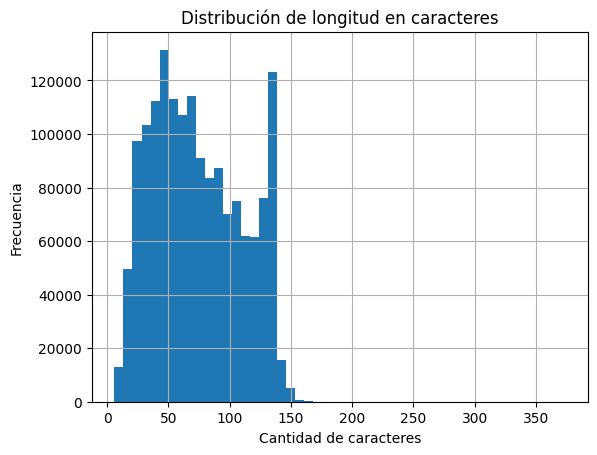

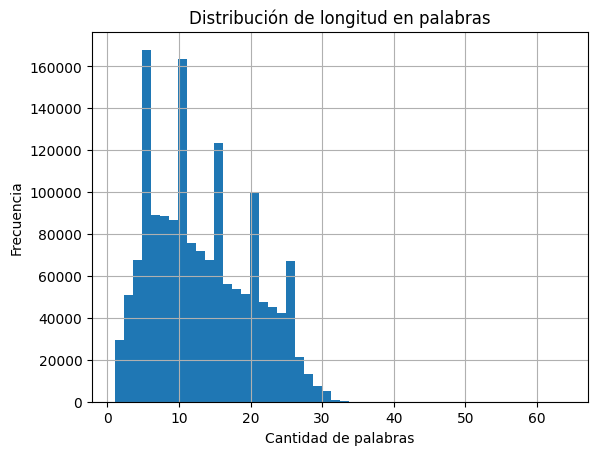

In [ ]:
import matplotlib.pyplot as plt

# caracteres
df_model['n_chars'].hist(bins=50)
plt.xlabel("Cantidad de caracteres")
plt.ylabel("Frecuencia")
plt.title("Distribución de longitud en caracteres")
plt.show()

# palabras
df_model['n_words'].hist(bins=50)
plt.xlabel("Cantidad de palabras")
plt.ylabel("Frecuencia")
plt.title("Distribución de longitud en palabras")
plt.show()

Son textos breves, informales y de alta densidad semántica por palabra, algo típico de redes sociales. Esto implica menos contexto por documento pero alta frecuencia de señales emocionales.

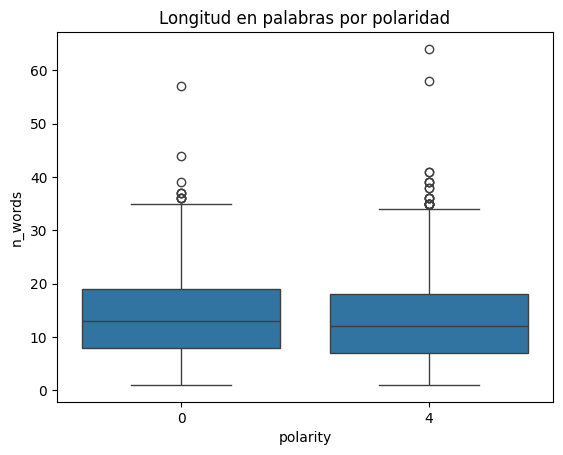

In [ ]:
import seaborn as sns  # si lo estás usando

sns.boxplot(data=df_model, x='polarity', y='n_words')
plt.title("Longitud en palabras por polaridad")
plt.show()

La longitud en palabras muestra distribuciones muy similares entre polaridad negativa (0) y positiva (4). Ambos presentan una mediana similar (~10 palabras) y un rango intercuartílico comparable (aprox. 6 a 15 palabras). Existen outliers hacia valores altos (>30 palabras), pero son poco frecuentes y aparecen en ambas clases. Por lo tanto, la longitud del texto no parece ser un discriminador fuerte del sentimiento.

In [ ]:
df_model.sort_values('n_words').head(10)[['polarity','text','n_words']]

,polarity,text,n_words
511087,0,Raining,1
193572,0,@youcollme,1
1020601,4,@waysideviolet,1
1183703,4,movieeeee.,1
270978,0,confuzzled....,1
270972,0,@Charliecondou,1
1020713,4,TGIF!!!!!!!!!!!!!!,1
1184200,4,Summersummersummer........,1
193469,0,Hiccups,1
270239,0,@stoopidgerl,1


Miro los tweets con menor cantidad de palabras. Coincide con menciones en algunos casos. Mas adelante eliminaré las menciones.

In [ ]:
df_model.sort_values('n_words', ascending=False).head(10)[['polarity','text','n_words']]

,polarity,text,n_words
1080011,4,? ? ? ? ? ? ? ?? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?...,64
1079511,4,? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?...,58
770356,0,I'm so boreeeeed. . . . . . . . . . . . . . . ...,57
461028,0,Is the saddest zornes ever thanks to the magic...,44
981534,4,@ajayrochester DO IT DO IT DO IT DO IT DO IT D...,41
1006771,4,"If E x N = 12, L + X = 4 and K-T = 1. What doe...",41
1097562,4,I'm blue Da ba dee da ba di da ba dee da ba di...,39
109664,0,"Who Am I Lying ! ? ! I Know , You Know , We Al...",39
1590300,4,4 I am high &amp; u can see. 4 I am lost &amp;...,39
971528,4,Shout out 2 all my followers .. I got it . I g...,39


Miro los tweets con mayor cantidad de palabras. Observo mucha repetición de caracteres continuos.

In [ ]:
df_model[df_model['n_words'] > 60][['text','n_words']].head()

,text,n_words
1080011,? ? ? ? ? ? ? ?? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?...,64


In [8]:
df_model[df_model['n_words'] <= 2][['text','n_words']].head()

KeyError: 'n_words'

Quiero borrar los tweetas que solo tienen el nombre de usuario y que solo tienen signos.


# Analizo si hay tweets que solo tengan signos

In [13]:
import re

solo_signos = df_model['text'].str.fullmatch(r'[\s\!\?\,\.\-]+')

In [ ]:
solo_signos.sum()

np.int64(0)

No hay tweets que solo tengan signos.

# Analizo si hay tweets que solo tengan nombres de usuarios

In [10]:
solo_users = df_model['text'].str.fullmatch(r'(\s*@\w+\s*)+')

In [ ]:
solo_users.sum()

np.int64(2606)

In [ ]:
df_model[solo_users][['text']].head(10)

,text
208,@mandayyy
249,@mandayyy
398,@danadearmond
430,@anistorm
1011,@citizensheep
1014,@GirlsGoneChild
1231,@thecoolestout
1421,@marlonjenglish
1486,@oishiieats
1641,@thisisguan


# Limpieza de tweets que solo contienen nombres de usuarios:

In [11]:
df_model = df_model[~solo_users].copy()

In [14]:
print("Total señales limpiadas:", solo_signos.sum() + solo_users.sum())
print(df_model.shape)

Total señales limpiadas: 2606
(1590499, 6)


# Features

In [37]:
import re
import numpy as np
# Crear copia del DF original
df_fe = df.copy()

# 1) Longitud básica
df_fe['n_chars']  = df_fe['text'].str.len()
df_fe['n_words']  = df_fe['text'].str.split().str.len()

# 2) Signos de puntuación
df_fe['n_excl'] = df_fe['text'].str.count('!')
df_fe['n_ques'] = df_fe['text'].str.count(r'\?')
df_fe['n_dots'] = df_fe['text'].str.count(r'\.')

# 3) Hashtags y menciones
df_fe['n_hashtags'] = df_fe['text'].str.count('#')
df_fe['n_users']    = df_fe['text'].str.count('@')

df_fe['has_hashtag'] = (df_fe['n_hashtags'] > 0).astype(int)
df_fe['has_user']    = (df_fe['n_users'] > 0).astype(int)

# 4) URLs
df_fe['has_url'] = df_fe['text'].str.contains(r'http[s]?://|www\.', regex=True).astype(int)

# 5) Ratio de mayúsculas (solo sobre letras)
def ratio_upper(text):
    letters = [c for c in text if c.isalpha()]
    if len(letters) == 0:
        return 0.0
    upp = sum(c.isupper() for c in letters)
    return upp / len(letters)

df_fe['ratio_upper'] = df_fe['text'].apply(ratio_upper)

# 6) Repetición máxima del mismo carácter (ej: "soooo" -> 4)
def max_char_run(text):
    if not text:
        return 0
    max_run = 1
    current_run = 1
    last = text[0]
    for c in text[1:]:
        if c == last:
            current_run += 1
            max_run = max(max_run, current_run)
        else:
            current_run = 1
        last = c
    return max_run

df_fe['max_char_run'] = df_fe['text'].apply(max_char_run)

# 7) Emojis (detección simple mediante rangos Unicode)
emoji_pattern = re.compile(
    "["
    u"\U0001F300-\U0001F5FF"  # símbolos y pictos
    u"\U0001F600-\U0001F64F"  # emoticones
    u"\U0001F680-\U0001F6FF"  # transporte / mapas
    u"\U0001F700-\U0001F77F"
    u"\U0001F780-\U0001F7FF"
    u"\U0001F800-\U0001F8FF"
    u"\U0001F900-\U0001F9FF"
    u"\U0001FA00-\U0001FAFF"
    "]+",
    flags=re.UNICODE
)

df_fe['has_emoji'] = df_fe['text'].apply(lambda x: int(bool(emoji_pattern.search(x))))

# 8) Proporción de signos de puntuación
punct_pattern = re.compile(r'[^\w\s]', re.UNICODE)

df_fe['n_punct'] = df_fe['text'].apply(lambda x: len(punct_pattern.findall(x)))

df_fe['ratio_punct'] = df_fe.apply(
    lambda row: row['n_punct'] / row['n_chars'] if row['n_chars'] > 0 else 0,
    axis=1
)

En esta etapa realizo ingeniería de atributos (feature engineering) aplicada sobre texto, con el objetivo de transformar características lingüísticas de los mensajes en variables numéricas que puedan ser utilizadas por los modelos de aprendizaje automático.

A partir del contenido del texto, genero métricas como:

longitud en caracteres y palabras,

cantidad de signos de exclamación y pregunta (intensidad emocional),

número de hashtags y menciones (interacción en redes),

presencia de URLs (contenido promocional o externo),

proporción de mayúsculas (énfasis o tono “gritado”),

repeticiones extensivas de un mismo carácter (exageración expresiva),

indicios de emojis.

Cada una de estas variables captura rasgos de estilo, énfasis, informalidad y emocionalidad, aspectos muy frecuentes en plataformas como Twitter y que suelen ser determinantes para tareas de clasificación de sentimiento.

El propósito de este trabajo es enriquecer el dataset con información adicional más allá del texto bruto, permitiendo que modelos supervisados como Regresión Logística o Naive Bayes cuenten con mayor contexto numérico para aprender patrones y mejorar su desempeño predictivo.

En síntesis, convierto señales lingüísticas en atributos cuantitativos para potenciar la capacidad del modelo de detectar matices emocionales y comportamentales del usuario que no serían capturados únicamente mediante embeddings o frecuencia de palabras.

In [38]:
df_fe[['n_chars','n_words','n_excl','n_ques',
       'n_hashtags','n_users','has_url','has_user',
       'has_emoji','ratio_upper','max_char_run','ratio_punct']].describe()

,n_chars,n_words,n_excl,n_ques,n_hashtags,n_users,has_url,has_user,has_emoji,ratio_upper,max_char_run,ratio_punct
count,1.600000e+06,1.600000e+06,1.600000e+06,1.600000e+06,1.600000e+06,1.600000e+06,1.600000e+06,1.600000e+06,1600000.0,1.600000e+06,1.600000e+06,1.600000e+06
mean,7.409011e+01,1.317615e+01,5.737188e-01,1.547263e-01,2.836250e-02,4.991762e-01,4.778938e-02,4.665200e-01,0.0,6.225007e-02,2.399676e+00,5.392502e-02
std,3.644114e+01,6.957978e+00,1.341294e+00,9.742050e-01,2.322000e-01,5.935093e-01,2.133204e-01,4.988780e-01,0.0,9.795112e-02,1.615394e+00,4.283458e-02
min,6.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,1.000000e+00,0.000000e+00
25%,4.400000e+01,7.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.149425e-02,2.000000e+00,2.702703e-02
50%,6.900000e+01,1.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,4.081633e-02,2.000000e+00,4.651163e-02
75%,1.040000e+02,1.900000e+01,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.0,7.619048e-02,3.000000e+00,7.194245e-02
max,3.740000e+02,6.400000e+01,1.120000e+02,1.110000e+02,5.800000e+01,1.300000e+01,1.000000e+00,1.000000e+00,0.0,1.000000e+00,1.120000e+02,8.901099e-01


In [ ]:
df_fe.groupby('polarity')[['n_excl','n_ques','has_url',
                          'has_user','has_hashtag',
                          'has_emoji','ratio_upper',
                          'max_char_run']].mean()

,n_excl,n_ques,has_url,has_user,has_hashtag,has_emoji,ratio_upper,max_char_run
polarity,,,,,,,,
0,0.482564,0.147135,0.031967,0.381003,0.01975,0.0,0.057833,2.443393
4,0.667552,0.163083,0.064052,0.551930,0.02644,0.0,0.066519,2.361678


Se observa que los tweets con polaridad 4 (positivos) tienden a ser más “expresivos” e interactivos que los de polaridad 0 (negativos). En promedio, los positivos usan más signos de exclamación y pregunta, incluyen con mayor frecuencia URLs, menciones a otros usuarios y hashtags, y presentan un ligero aumento en la proporción de mayúsculas, lo que sugiere un tono más enfático o entusiasta. En cambio, la repetición máxima de caracteres es muy similar entre ambas clases y la presencia de emojis es prácticamente nula, pero voy a profundizar en los emojis mas adelante.

# EMOJIS

In [ ]:
import re

emoji_pattern = re.compile(
    "["
    u"\U0001F300-\U0001F5FF"  # símbolos y pictogramas
    u"\U0001F600-\U0001F64F"  # emoticonos
    u"\U0001F680-\U0001F6FF"  # transporte/mapa
    u"\U0001F700-\U0001F77F"
    u"\U0001F780-\U0001F7FF"
    u"\U0001F800-\U0001F8FF"
    u"\U0001F900-\U0001F9FF"
    u"\U0001FA00-\U0001FA6F"
    u"\U0001FA70-\U0001FAFF"
    "]+",
    flags=re.UNICODE
)

df_fe['has_emoji'] = df_fe['text'].apply(lambda x: bool(emoji_pattern.search(x)))
df_fe['has_emoji'].sum()

np.int64(0)

In [ ]:
import re

emoticon_pattern = re.compile(
    r'(:\)|:-\)|:\]|:D|:-D|=\)|=\]|XD|xD|;\)|;-\)|:-P|:P|=P|'  # positivos
    r':\(|:-\(|:\[|=\(|;\(|T_T|D:|:-/|:/|>: \(|>:\(|:\'\(|:\'\)|'  # negativos
    r'<3|♥)',  # amor
    flags=re.IGNORECASE
)

In [ ]:
df_fe['has_emoticon'] = df_fe['text'].apply(lambda x: int(bool(emoticon_pattern.search(x))))

In [ ]:
df_fe['has_emoticon'].sum()

np.int64(95695)

In [ ]:
df_fe.groupby('polarity')['has_emoticon'].mean()

,has_emoticon
polarity,
0,0.044989
4,0.075330


# Valido tweets con emoticones

In [ ]:
df_fe[df_fe['has_emoticon'] == 1][['text','polarity']].head(20)

,text,polarity
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
37,@MissXu sorry! bed time came here (GMT+1) ht...,0
50,Broadband plan 'a massive broken promise' http...,0
74,Why won't you show my location?! http://twit...,0
95,Strider is a sick little puppy http://apps.fa...,0
100,Body Of Missing Northern Calif. Girl Found: P...,0
106,Emily will be glad when Mommy is done training...,0
170,Crazy wind today = no birding http://ff.im/1XTTi,0
181,Check out my mug http://www.erika-obscura.blo...,0
218,@infinitydefines omgawd i couldnt handle my c...,0


Me aparecen tweets sin emoticones porque el código está interpretando URL como emoticones

# Limpio los URL

In [ ]:
import re

# regex para URLs
url_pattern = re.compile(r'http[s]?://\S+|www\.\S+', flags=re.IGNORECASE)

def remove_urls(text):
    return url_pattern.sub("", text)

df_fe['text_no_url'] = df_fe['text'].apply(remove_urls)

# Evalúo devuelta los emoticones:

In [ ]:
emoticon_pattern = re.compile(
    r'(:\)|:-\)|:\]|:D|:-D|=\)|=\]|XD|xD|;\)|;-\)|:-P|:P|=P|'
    r':\(|:-\(|:\[|=\(|;\(|T_T|D:|:-/|:/|>:\(|>:\(|:\'\(|:\'\)|'
    r'<3|♥)',
    flags=re.IGNORECASE
)

df_fe['has_emoticon'] = df_fe['text_no_url'].apply(lambda x: int(bool(emoticon_pattern.search(x))))

In [ ]:
df_fe[df_fe['has_emoticon'] == 1][['text','text_no_url']].head(20)

,text,text_no_url
100,Body Of Missing Northern Calif. Girl Found: P...,Body Of Missing Northern Calif. Girl Found: P...
218,@infinitydefines omgawd i couldnt handle my c...,@infinitydefines omgawd i couldnt handle my c...
305,"Argh! I was suuuper sleepy an hour ago, now I'...","Argh! I was suuuper sleepy an hour ago, now I'..."
464,"My bathtub drain is fired: it haz 1 job 2 do, ...","My bathtub drain is fired: it haz 1 job 2 do, ..."
539,"@KelleyRowe hey, you remember that time we use...","@KelleyRowe hey, you remember that time we use..."
701,Re-pinging @Kyle44: Custom icons I made! =] lo...,Re-pinging @Kyle44: Custom icons I made! =] lo...
860,@reannaremick doesnt work on my cell go to sl...,@reannaremick doesnt work on my cell go to sl...
1063,@_saffron Why not? :[,@_saffron Why not? :[
1234,@Glavas lol. U read my bio but spelt my name ...,@Glavas lol. U read my bio but spelt my name ...
1311,@cyantificNHS Balls Although without the tune...,@cyantificNHS Balls Although without the tune...


In [ ]:
import re

# positivos: alegría, risa, guiño, amor
pos_emoticon_pattern = re.compile(
    r'(:\)|:-\)|:\]|:D|:-D|=\)|=\]|XD|xD|;\)|;-\)|:-P|:P|=P|<3|\(:)',
    flags=re.IGNORECASE
)

# negativos: tristeza, bronca, confusión
neg_emoticon_pattern = re.compile(
    r'(:\(|:-\(|:\[|=\(|;\(|T_T|D:|:-/|:/|>:\(|:\'\(|:\'\))',
    flags=re.IGNORECASE
)

In [ ]:
# binarios: al menos uno
df_fe['has_pos_emoticon'] = df_fe['text_no_url'].apply(
    lambda x: int(bool(pos_emoticon_pattern.search(x)))
)

df_fe['has_neg_emoticon'] = df_fe['text_no_url'].apply(
    lambda x: int(bool(neg_emoticon_pattern.search(x)))
)

# conteo (opcional)
df_fe['n_pos_emoticons'] = df_fe['text_no_url'].apply(
    lambda x: len(pos_emoticon_pattern.findall(x))
)

df_fe['n_neg_emoticons'] = df_fe['text_no_url'].apply(
    lambda x: len(neg_emoticon_pattern.findall(x))
)

In [ ]:
df_fe.groupby('polarity')[['has_pos_emoticon','has_neg_emoticon',
                           'n_pos_emoticons','n_neg_emoticons']].mean()

,has_pos_emoticon,has_neg_emoticon,n_pos_emoticons,n_neg_emoticons
polarity,,,,
0,0.009581,0.006843,0.009955,0.007104
4,0.015608,0.004267,0.016258,0.004364


La presencia de emoticones ASCII es baja (≈1–2% de los tweets). Se observa un patrón coherente con el sentimiento: los tweets positivos presentan una mayor proporción de emoticones positivos (1,56% vs 0,96% en negativos), mientras que los emoticones negativos aparecen ligeramente más en la clase negativa (0,68% vs 0,43%). No obstante, debido a su baja frecuencia, estas variables aportan una señal emocional débil pero consistente, más útil como feature complementaria que como factor principal.

# Continúo con el análisis de los features:

In [ ]:
features_num = [
    "n_chars", "n_words",
    "n_excl", "n_ques",
    "n_hashtags", "n_users",
    "has_url", "has_user", "has_hashtag",
    "ratio_upper", "max_char_run",
    "has_pos_emoticon", "has_neg_emoticon"
]

df_fe.groupby('polarity')[features_num].describe().T

polarity                            0              4
n_chars          count  794875.000000  795624.000000
                 mean       74.515033      74.031935
                 std        36.602737      36.022355
                 min         6.000000       6.000000
                 25%        44.000000      44.000000
...                               ...            ...
has_neg_emoticon min         0.000000       0.000000
                 25%         0.000000       0.000000
                 50%         0.000000       0.000000
                 75%         0.000000       0.000000
                 max         1.000000       1.000000

[104 rows x 2 columns]

In [ ]:
df_fe.groupby('polarity')[features_num].mean().T

polarity,0,4
n_chars,74.515033,74.031935
n_words,13.623207,12.797032
n_excl,0.482564,0.667552
n_ques,0.147135,0.163083
n_hashtags,0.023911,0.032743
n_users,0.401886,0.596510
has_url,0.031967,0.064052
has_user,0.381003,0.551930
has_hashtag,0.019750,0.026440
ratio_upper,0.057833,0.066519


En síntesis, la señal de sentimiento no viene tanto del largo del texto, sino de cómo se escribe: más signos, menciones, hashtags, URLs y emoticones positivos se asocian con tweets de polaridad positiva.

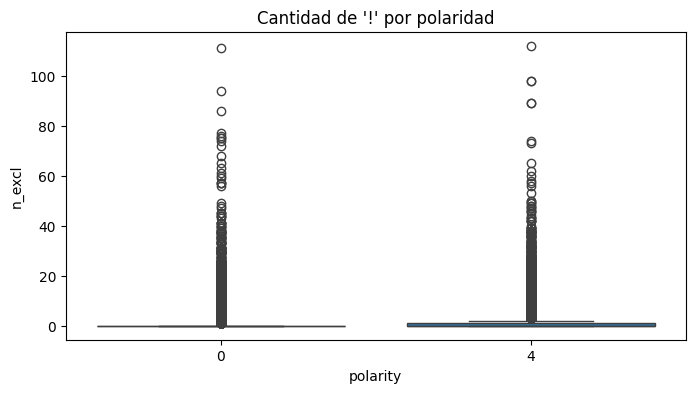

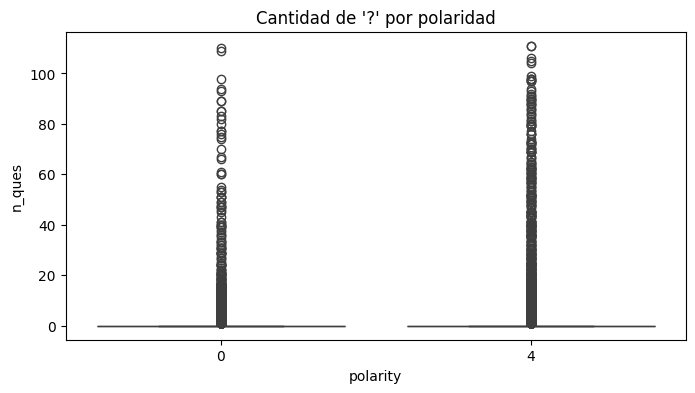

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.boxplot(data=df_fe, x='polarity', y='n_excl')
plt.title("Cantidad de '!' por polaridad")
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(data=df_fe, x='polarity', y='n_ques')
plt.title("Cantidad de '?' por polaridad")
plt.show()

Los signos de exclamación y pregunta no separan limpiamente los grupos —hay mucho ruido— pero cuando aparecen en grandes cantidades suelen asociarse más con tweets positivos.

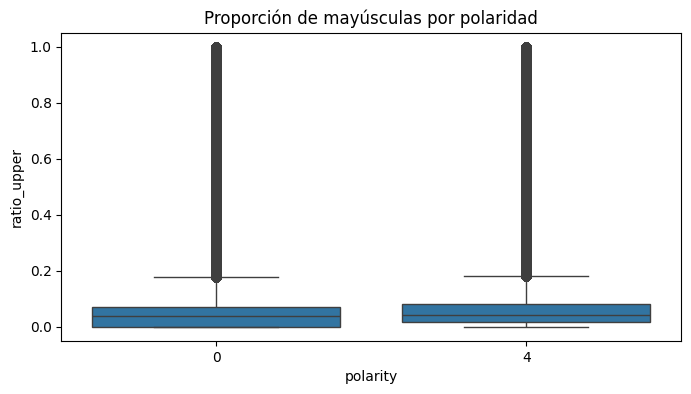

In [ ]:
plt.figure(figsize=(8,4))
sns.boxplot(data=df_fe, x='polarity', y='ratio_upper')
plt.title("Proporción de mayúsculas por polaridad")
plt.show()

La proporción de mayúsculas es muy similar entre tweets positivos (4) y negativos (0).

La mediana en ambos grupos está cerca de 0 (muy pocas mayúsculas respecto del total de letras).

Hay muchos valores atípicos (outliers) en ambos extremos, lo que significa que existen tweets “GRITADOS” completamente en mayúscula, pero aparecen en ambas polaridades, no solo en una.

El rango intercuartílico es prácticamente el mismo: la mayoría de los usuarios no usa mayúsculas de forma intensiva.

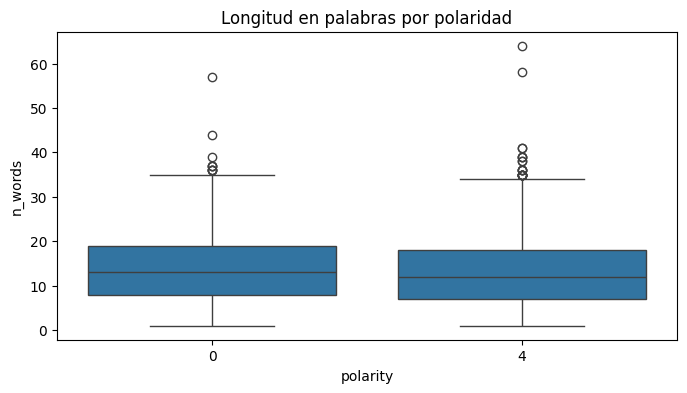

In [ ]:
plt.figure(figsize=(8,4))
sns.boxplot(data=df_fe, x='polarity', y='n_words')
plt.title("Longitud en palabras por polaridad")
plt.show()

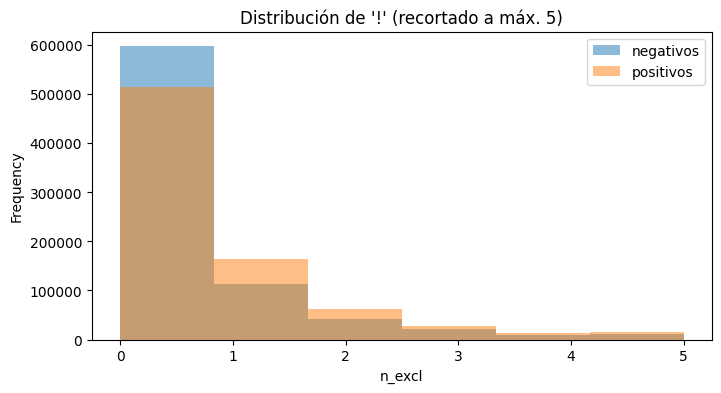

In [ ]:
plt.figure(figsize=(8,4))
for p, color, label in [(0, "tab:blue", "negativos"), (4, "tab:orange", "positivos")]:
    subset = df_fe[df_fe['polarity'] == p]
    subset['n_excl'].clip(upper=5).plot(kind='hist', alpha=0.5, label=label, bins=6)
plt.legend()
plt.title("Distribución de '!' (recortado a máx. 5)")
plt.xlabel("n_excl")
plt.show()

In [ ]:
bin_features = ["has_url", "has_user", "has_hashtag",
                "has_pos_emoticon", "has_neg_emoticon"]

df_fe.groupby('polarity')[bin_features].mean()

,has_url,has_user,has_hashtag,has_pos_emoticon,has_neg_emoticon
polarity,,,,,
0,0.031967,0.381003,0.01975,0.009581,0.006843
4,0.064052,0.551930,0.02644,0.015608,0.004267


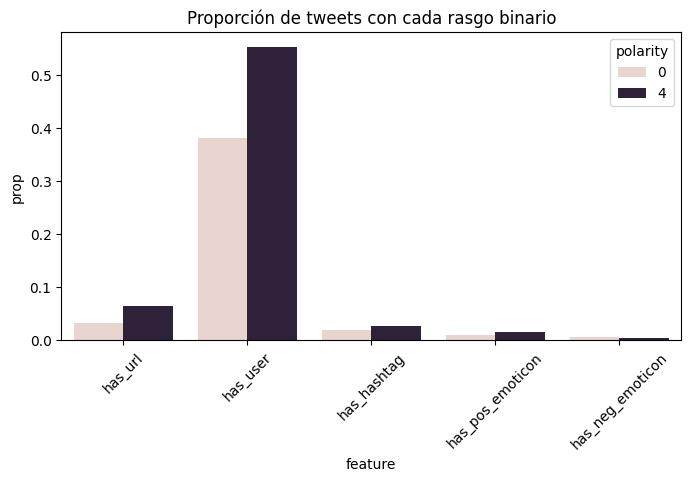

In [ ]:
df_bin = df_fe.groupby('polarity')[bin_features].mean().reset_index()
df_bin_melt = df_bin.melt(id_vars='polarity', var_name='feature', value_name='prop')

plt.figure(figsize=(8,4))
sns.barplot(data=df_bin_melt, x='feature', y='prop', hue='polarity')
plt.xticks(rotation=45)
plt.title("Proporción de tweets con cada rasgo binario")
plt.show()

Las variables binarias muestran patrones sociolingüísticos claros: los tweets positivos son más interactivos (mayor presencia de menciones @), comparten más URLs y utilizan ligeramente más hashtags. Las señales emocionales visuales (emoticonos) son coherentes con el sentimiento, pero su frecuencia es muy reducida (1–2%), por lo que aportan información marginal. En conjunto, estas features no reemplazan al texto, pero enriquecen la representación capturando rasgos sociales y expresivos que el vectorizador no modela explícitamente.

# Dataset con features:

In [16]:
df_model_fe = df_model.copy()

In [17]:
df_model_fe['n_chars'] = df_model_fe['text'].str.len()
df_model_fe['n_words'] = df_model_fe['text'].str.split().str.len()

In [18]:
df_model_fe['n_excl'] = df_model_fe['text'].str.count('!')
df_model_fe['n_ques'] = df_model_fe['text'].str.count(r'\?')
df_model_fe['n_dots'] = df_model_fe['text'].str.count(r'\.')

In [19]:
df_model_fe['n_hashtags'] = df_model_fe['text'].str.count('#')
df_model_fe['n_users']    = df_model_fe['text'].str.count('@')

df_model_fe['has_user']     = (df_model_fe['n_users'] > 0).astype(int)
df_model_fe['has_hashtag']  = (df_model_fe['n_hashtags'] > 0).astype(int)

In [20]:
df_model_fe['has_url'] = df_model_fe['text'].str.contains(r'http[s]?://|www\.', regex=True).astype(int)

In [21]:
def ratio_upper(text):
    letters = [c for c in text if c.isalpha()]
    if len(letters) == 0:
        return 0.0
    return sum(c.isupper() for c in letters) / len(letters)

df_model_fe['ratio_upper'] = df_model_fe['text'].apply(ratio_upper)

# Análisis linguistico

# LImipeza del dataset para análisis linguistico:

In [22]:
import re

def basic_clean(text):
    text = text.lower()
    # sacar urls
    text = re.sub(r'http[s]?://\S+|www\.\S+', ' ', text)
    # sacar @usuarios
    text = re.sub(r'@\w+', ' ', text)
    # sacar el símbolo # (pero dejar la palabra)
    text = re.sub(r'#', ' ', text)
    # quedarme solo con letras y espacios
    text = re.sub(r'[^a-z\s]', ' ', text)
    # espacios múltiples -> uno solo
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_model_fe['clean_text'] = df_model_fe['text'].apply(basic_clean)

Para el entrenamiento del modelo de clasificación, opté por remover del texto elementos como URLs, menciones a usuarios, hashtags y caracteres no alfabéticos. Esta depuración busca reducir ruido léxico y asegurar que el modelo se concentre en patrones lingüísticos reales (palabras, estructura y vocabulario), evitando tokens poco informativos o altamente variables.

Sin embargo, en lugar de descartar completamente esa información, la conservo mediante variables numéricas derivadas (features) que capturan su presencia e intensidad

# Top palabras globales

In [ ]:
import re

def basic_clean(text):
    text = text.lower()
    # sacar urls
    text = re.sub(r'http[s]?://\S+|www\.\S+', ' ', text)
    # sacar @usuarios
    text = re.sub(r'@\w+', ' ', text)
    # sacar el símbolo # (pero dejar la palabra)
    text = re.sub(r'#', ' ', text)
    # quedarme solo con letras y espacios
    text = re.sub(r'[^a-z\s]', ' ', text)
    # espacios múltiples -> uno solo
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_model_fe['clean_text'] = df_model_fe['text'].apply(basic_clean)

# Top palabras por polaridad

In [ ]:
from collections import Counter

def top_words_for_class(df, polarity, n=20):
    tokens = " ".join(df.loc[df['polarity']==polarity, 'clean_text']).split()
    return Counter(tokens).most_common(n)

top_neg_words = top_words_for_class(df_model_fe, 0, n=20)
top_pos_words = top_words_for_class(df_model_fe, 4, n=20)

top_neg_words, top_pos_words

([('i', 573830),
  ('to', 311967),
  ('the', 257138),
  ('my', 190234),
  ('a', 183396),
  ('it', 156971),
  ('and', 153595),
  ('is', 127612),
  ('t', 125627),
  ('in', 115212),
  ('you', 103286),
  ('for', 98617),
  ('of', 92493),
  ('s', 92468),
  ('me', 91641),
  ('so', 88269),
  ('but', 84485),
  ('on', 83906),
  ('that', 82686),
  ('have', 82614)],
 [('i', 381406),
  ('the', 265312),
  ('to', 251633),
  ('a', 199687),
  ('you', 197885),
  ('and', 149274),
  ('it', 147331),
  ('my', 125550),
  ('for', 117060),
  ('is', 108585),
  ('in', 100846),
  ('s', 97719),
  ('of', 90856),
  ('on', 83937),
  ('that', 82984),
  ('me', 71380),
  ('so', 65396),
  ('with', 65045),
  ('just', 62688),
  ('have', 62484)])

# Bigramas

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# bigramas globales
bigram_vectorizer = CountVectorizer(ngram_range=(2,2),
                                    min_df=10,       # solo los que aparecen al menos 10 veces
                                    stop_words='english')

X_big = bigram_vectorizer.fit_transform(df_model_fe['clean_text'])
bigram_freq = np.asarray(X_big.sum(axis=0)).ravel()
bigram_terms = bigram_vectorizer.get_feature_names_out()

top_bigrams_global = sorted(
    zip(bigram_terms, bigram_freq),
    key=lambda x: x[1],
    reverse=True
)[:20]

top_bigrams_global

[('just got', np.int64(11317)),
 ('good morning', np.int64(9946)),
 ('don know', np.int64(6711)),
 ('feel like', np.int64(6556)),
 ('looking forward', np.int64(5603)),
 ('looks like', np.int64(5185)),
 ('good luck', np.int64(5073)),
 ('getting ready', np.int64(4902)),
 ('good night', np.int64(4730)),
 ('don want', np.int64(4444)),
 ('good day', np.int64(3987)),
 ('ve got', np.int64(3797)),
 ('going bed', np.int64(3693)),
 ('happy birthday', np.int64(3627)),
 ('don think', np.int64(3603)),
 ('let know', np.int64(3557)),
 ('quot quot', np.int64(3552)),
 ('great day', np.int64(3416)),
 ('feel better', np.int64(3404)),
 ('sounds like', np.int64(3255))]

# Bigramas por polaridad

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
def top_bigrams_for_class(df, polarity, n=20):
    vec = CountVectorizer(ngram_range=(2,2),
                          min_df=5,
                          stop_words='english')
    X = vec.fit_transform(df.loc[df['polarity']==polarity, 'clean_text'])
    freqs = np.asarray(X.sum(axis=0)).ravel()
    terms = vec.get_feature_names_out()
    return sorted(zip(terms, freqs), key=lambda x: x[1], reverse=True)[:n]

top_big_neg = top_bigrams_for_class(df_model_fe, 0, n=20)
top_big_pos = top_bigrams_for_class(df_model_fe, 4, n=20)

top_big_neg, top_big_pos

([('just got', np.int64(5527)),
  ('feel like', np.int64(5131)),
  ('don know', np.int64(4668)),
  ('don want', np.int64(3751)),
  ('looks like', np.int64(3321)),
  ('don think', np.int64(2537)),
  ('sorry hear', np.int64(2461)),
  ('looking forward', np.int64(2184)),
  ('getting ready', np.int64(2119)),
  ('feel better', np.int64(2094)),
  ('don like', np.int64(2064)),
  ('ve got', np.int64(2008)),
  ('good morning', np.int64(1928)),
  ('going bed', np.int64(1868)),
  ('work today', np.int64(1793)),
  ('just woke', np.int64(1787)),
  ('don wanna', np.int64(1777)),
  ('work tomorrow', np.int64(1770)),
  ('gonna miss', np.int64(1718)),
  ('dont know', np.int64(1717))],
 [('good morning', np.int64(8018)),
  ('just got', np.int64(5790)),
  ('good luck', np.int64(3911)),
  ('good night', np.int64(3779)),
  ('looking forward', np.int64(3419)),
  ('happy birthday', np.int64(3153)),
  ('good day', np.int64(2929)),
  ('great day', np.int64(2839)),
  ('getting ready', np.int64(2783)),
  ('let k

# TF-IDF exploratorio

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tfidf_vec = TfidfVectorizer(
    stop_words='english',
    min_df=5,
    max_df=0.9,
    ngram_range=(1, 2)   # unigrams + bigrams
)

X_tfidf = tfidf_vec.fit_transform(df_model_fe['clean_text'])
feature_names = tfidf_vec.get_feature_names_out()

# --- CORRECCIÓN 1: convertir las máscaras a arrays de NumPy (.values) ---
mask_neg = (df_model_fe['polarity'] == 0).values
mask_pos = (df_model_fe['polarity'] == 4).values

# medias de TF-IDF por clase
mean_tfidf_neg = X_tfidf[mask_neg].mean(axis=0).A1
mean_tfidf_pos = X_tfidf[mask_pos].mean(axis=0).A1

# --- términos más característicos de la clase positiva (pos >> neg) ---
scores_pos = mean_tfidf_pos - mean_tfidf_neg

# CORRECCIÓN 2: argsort para tomar los 20 mayores correctamente
top_pos_idx = scores_pos.argsort()[-20:][::-1]
top_pos_terms = [(feature_names[i], scores_pos[i]) for i in top_pos_idx]

# --- términos más característicos de la clase negativa (neg >> pos) ---
scores_neg = mean_tfidf_neg - mean_tfidf_pos
top_neg_idx = scores_neg.argsort()[-20:][::-1]
top_neg_terms = [(feature_names[i], scores_neg[i]) for i in top_neg_idx]

top_pos_terms, top_neg_terms

([('thanks', np.float64(0.010435751974271578)),
  ('good', np.float64(0.007747899966037547)),
  ('love', np.float64(0.007304867795211292)),
  ('thank', np.float64(0.006065221834229096)),
  ('great', np.float64(0.004306858558461328)),
  ('happy', np.float64(0.004074320333962554)),
  ('quot', np.float64(0.0036325703706828636)),
  ('welcome', np.float64(0.0033930976799043033)),
  ('awesome', np.float64(0.0033492863887422605)),
  ('lol', np.float64(0.0032495504834224387)),
  ('hey', np.float64(0.003192420512251678)),
  ('haha', np.float64(0.003159546904569905)),
  ('nice', np.float64(0.0030044835276238097)),
  ('morning', np.float64(0.00295098091952192)),
  ('good morning', np.float64(0.0027276387835065722)),
  ('new', np.float64(0.0027046938535387585)),
  ('yay', np.float64(0.002547452836844245)),
  ('follow', np.float64(0.002374178720857461)),
  ('yes', np.float64(0.0023675605336856273)),
  ('fun', np.float64(0.002321737118963178))],
 [('miss', np.float64(0.0074208285899836635)),
  ('sad

# Nubes de palabras por polaridad

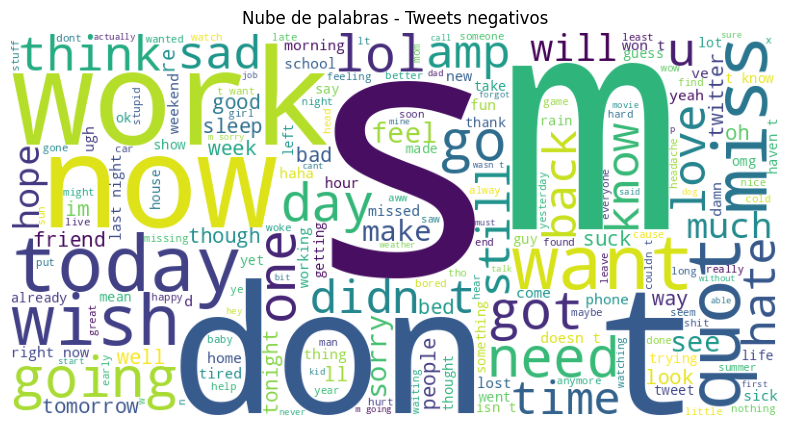

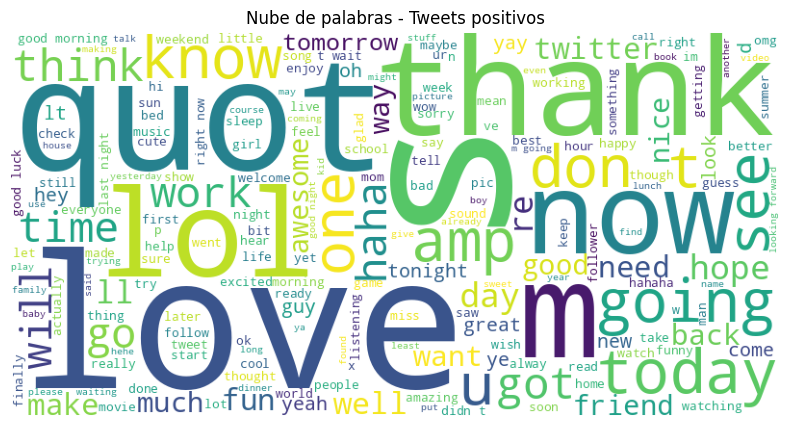

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# textos unidos por clase
text_neg = " ".join(df_model_fe.loc[df_model_fe['polarity']==0, 'clean_text'])
text_pos = " ".join(df_model_fe.loc[df_model_fe['polarity']==4, 'clean_text'])

# nube negativos
wc_neg = WordCloud(width=800, height=400,
                   background_color="white").generate(text_neg)
plt.figure(figsize=(10,5))
plt.imshow(wc_neg)
plt.axis("off")
plt.title("Nube de palabras - Tweets negativos")
plt.show()

# nube positivos
wc_pos = WordCloud(width=800, height=400,
                   background_color="white").generate(text_pos)
plt.figure(figsize=(10,5))
plt.imshow(wc_pos)
plt.axis("off")
plt.title("Nube de palabras - Tweets positivos")
plt.show()

Según mi entendimiento: las nubes de palabras muestran que ambos tipos de tweets comparten términos ligados al tiempo y a la vida diaria (now, time, today, need, etc.), pero el tono cambia según la polaridad. En los tweets negativos predominan palabras asociadas a frustración, cansancio y carencia (sad, miss, hate, tired, wish), lo que refleja nostalgia, queja e insatisfacción. En los positivos aparecen con más fuerza palabras de afecto, gratitud y humor (love, thank, haha, fun, awesome), que expresan disfrute y celebración. El humor (“haha”, “lol”) casi solo aparece en los positivos, y “love” se usa como emoción directa allí, mientras que en los negativos suele aparecer en contextos de falta o añoranza. Ambos hablan del presente (now, today), pero los positivos lo celebran y los negativos lo viven con más resignación o urgencia.

# Temporalidad

# Columnas de tiempo

In [23]:
# 1) Pasar la columna date a datetime
df_model_fe['dt'] = pd.to_datetime(df_model_fe['date'])

# 2) Extraer componentes
df_model_fe['year']      = df_model_fe['dt'].dt.year
df_model_fe['month']     = df_model_fe['dt'].dt.month
df_model_fe['day']       = df_model_fe['dt'].dt.day
df_model_fe['weekday']   = df_model_fe['dt'].dt.day_name()   # nombre del día
df_model_fe['hour']      = df_model_fe['dt'].dt.hour
df_model_fe['date_only'] = df_model_fe['dt'].dt.date         # solo fecha (sin hora)

/tmp/ipython-input-192084858.py:2: FutureWarning: Parsed string "Mon Apr 06 22:19:45 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df_model_fe['dt'] = pd.to_datetime(df_model_fe['date'])


# Volumen de tweets en el tiempo

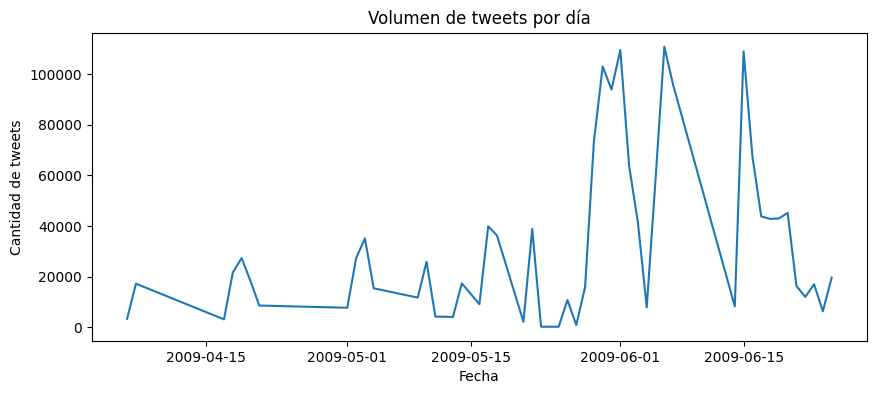

In [ ]:
tweets_por_dia = df_model_fe.groupby('date_only').size()

tweets_por_dia.plot(kind='line', figsize=(10,4))
plt.title("Volumen de tweets por día")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de tweets")
plt.show()

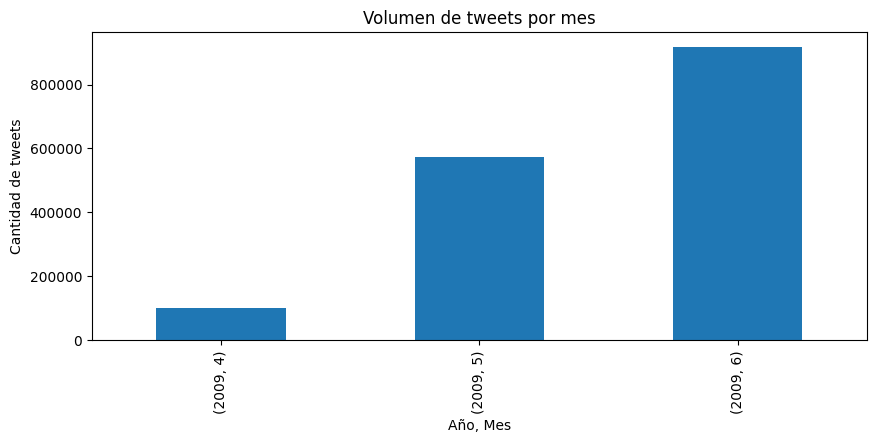

In [ ]:
tweets_por_mes = df_model_fe.groupby([df_model_fe['year'], df_model_fe['month']]).size()
tweets_por_mes.plot(kind='bar', figsize=(10,4))
plt.title("Volumen de tweets por mes")
plt.xlabel("Año, Mes")
plt.ylabel("Cantidad de tweets")
plt.show()

El crecimiento explosivo del volumen implica riesgo de sesgo temporal y aprendizaje distorsionado. El modelo puede volverse muy bueno prediciendo junio, pero menos robusto para otros períodos.

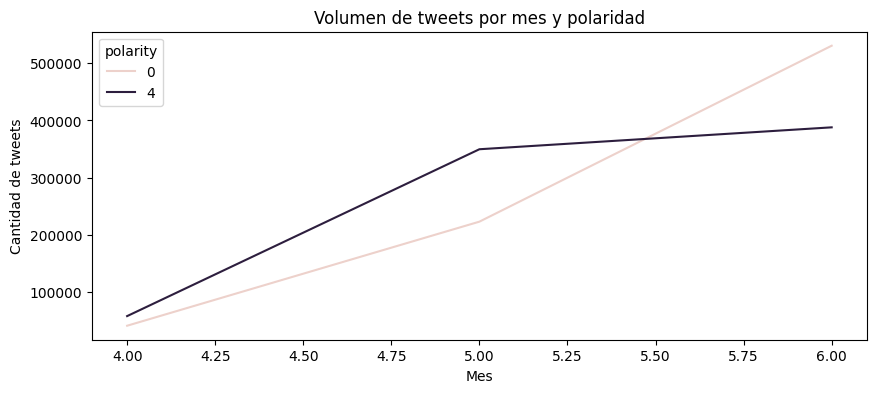

In [ ]:
sent_mes = df_model_fe.groupby(['year','month','polarity']).size().reset_index(name='count')

plt.figure(figsize=(10,4))
sns.lineplot(data=sent_mes, x='month', y='count', hue='polarity')
plt.title("Volumen de tweets por mes y polaridad")
plt.xlabel("Mes")
plt.ylabel("Cantidad de tweets")
plt.show()

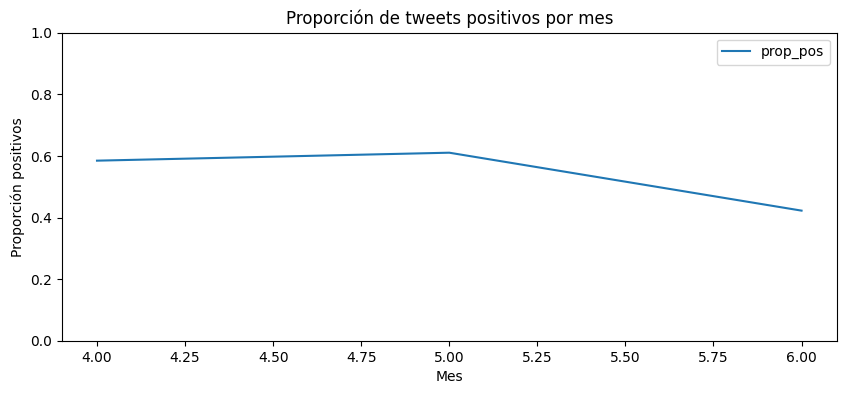

In [ ]:
sent_mes_tot = df_model_fe.groupby(['year','month'])['polarity'].apply(
    lambda s: (s==4).mean()
).reset_index(name='prop_pos')

sent_mes_tot.plot(x='month', y='prop_pos', kind='line', figsize=(10,4))
plt.title("Proporción de tweets positivos por mes")
plt.xlabel("Mes")
plt.ylabel("Proporción positivos")
plt.ylim(0,1)
plt.show()

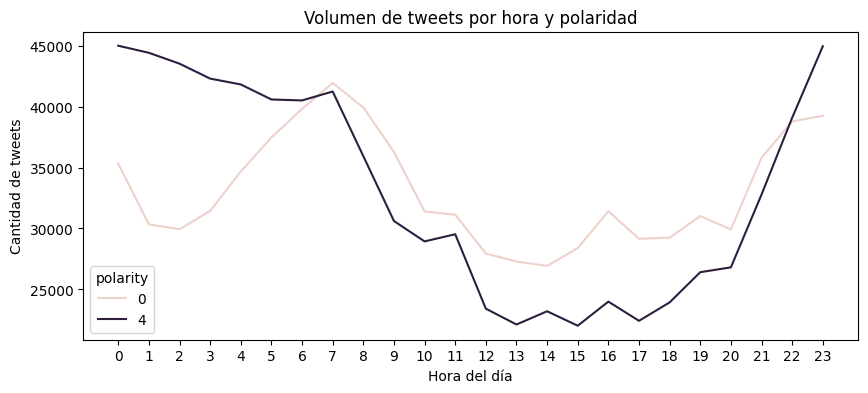

In [ ]:
sent_hora = df_model_fe.groupby(['hour','polarity']).size().reset_index(name='count')

plt.figure(figsize=(10,4))
sns.lineplot(data=sent_hora, x='hour', y='count', hue='polarity')
plt.title("Volumen de tweets por hora y polaridad")
plt.xlabel("Hora del día")
plt.ylabel("Cantidad de tweets")
plt.xticks(range(0,24))
plt.show()

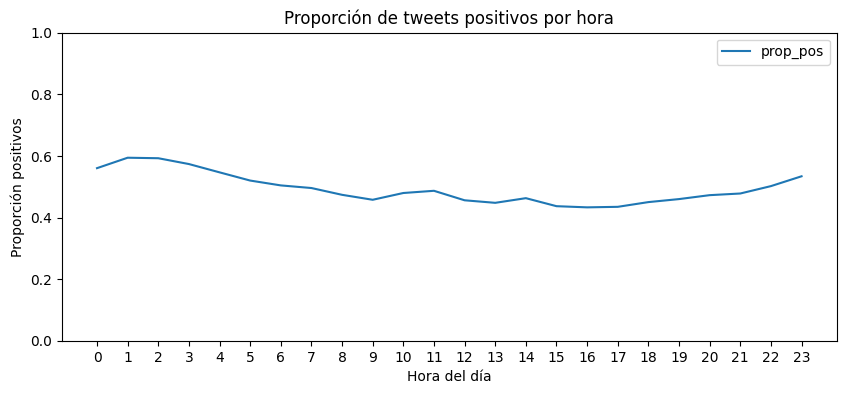

In [ ]:
prop_pos_hora = df_model_fe.groupby('hour')['polarity'].apply(
    lambda s: (s==4).mean()
).reset_index(name='prop_pos')

prop_pos_hora.plot(x='hour', y='prop_pos', kind='line', figsize=(10,4))
plt.title("Proporción de tweets positivos por hora")
plt.xlabel("Hora del día")
plt.ylabel("Proporción positivos")
plt.ylim(0,1)
plt.xticks(range(0,24))
plt.show()

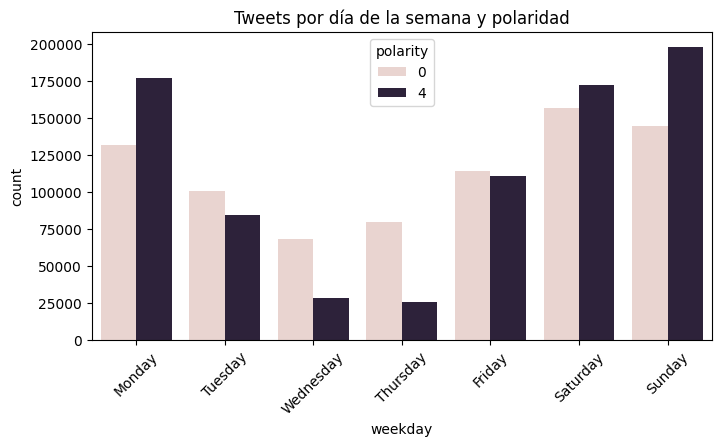

In [ ]:
sent_weekday = df_model_fe.groupby(['weekday','polarity']).size().reset_index(name='count')

plt.figure(figsize=(8,4))
sns.barplot(data=sent_weekday, x='weekday', y='count', hue='polarity',
            order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title("Tweets por día de la semana y polaridad")
plt.xticks(rotation=45)
plt.show()

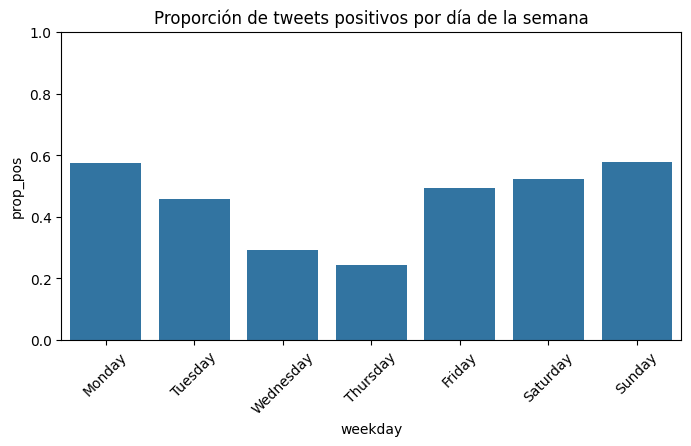

In [ ]:
prop_pos_weekday = df_model_fe.groupby('weekday')['polarity'].apply(
    lambda s: (s==4).mean()
).reset_index(name='prop_pos')

plt.figure(figsize=(8,4))
sns.barplot(data=prop_pos_weekday, x='weekday', y='prop_pos',
            order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title("Proporción de tweets positivos por día de la semana")
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.show()

# Conclusión análisis temporal:

Evolución mensual

El volumen total de tweets crece de abril a junio para ambas polaridades.

Sin embargo, la proporción de tweets positivos sube de abril a mayo y luego cae fuerte en junio: junio tiene muchos más tweets, pero relativamente más negativos.

Proporción de positivos por mes

Abril y mayo tienen una mayor participación de tweets positivos (cerca de 60%).

En junio la proporción de positivos baja a ~40%, lo que sugiere un cambio de tono hacia lo negativo a pesar del aumento de actividad.

Patrón horario

Los tweets positivos (polarity 4) son más altos a la medianoche y madrugada, caen durante la mañana y tocan un piso hacia el mediodía, para luego volver a subir fuerte a la noche (especialmente 22–23 hs).

Los tweets negativos (polarity 0) tienen picos más marcados en la mañana (alrededor de las 6–8 hs) y se mantienen relativamente altos durante el día.
→ En resumen: el tono es más negativo en horario diurno y más positivo en franjas nocturnas.

Día de la semana

Lunes y fin de semana (sábado y domingo) concentran más tweets positivos que negativos.

Martes, miércoles y jueves muestran mayor volumen de tweets negativos, lo que indica una inclinación más crítica en días laborales “duros”.

El viernes está más balanceado entre positivo y negativo.

En esta etapa no apliqué ningún tratamiento específico sobre la dimensión temporal (por ejemplo, separación por períodos, balanceo por mes o validación temporal), pero identifico esta decisión como una mejora potencial para futuras iteraciones del modelo.

# Usuarios / hashtags / menciones

# Top usuarios (autores más activos)

In [ ]:
top_users = df_model_fe['user'].value_counts().head(20)
top_users

,count
user,
lost_dog,549
webwoke,345
tweetpet,310
SallytheShizzle,281
VioletsCRUK,279
mcraddictal,273
tsarnick,248
what_bugs_u,246
Karen230683,238


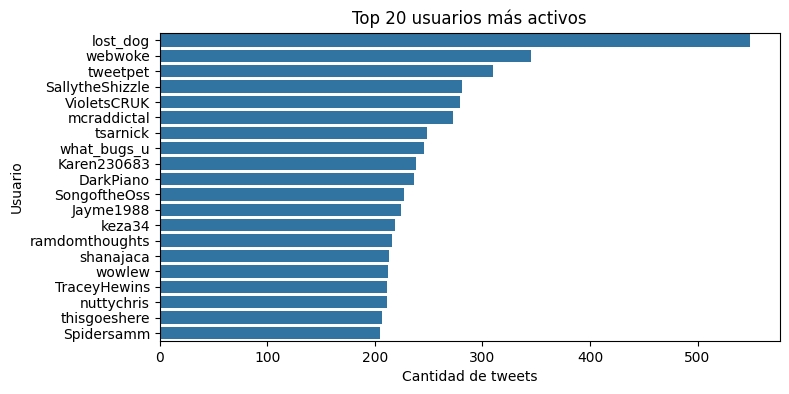

In [ ]:
plt.figure(figsize=(8,4))
sns.barplot(y=top_users.index, x=top_users.values)
plt.title("Top 20 usuarios más activos")
plt.xlabel("Cantidad de tweets")
plt.ylabel("Usuario")
plt.show()

Hay unos pocos usuarios hiperactivos que concentran gran parte de los tweets.

En particular, lost_dog twittea notablemente más que el resto (supera los 550 tweets), muy por encima del segundo (webwoke) y tercero (tweetpet).

Después del primero, el volumen cae de forma gradual, pero aun así el grupo Top 20 sigue teniendo una actividad muy alta respecto del usuario promedio del dataset.

Esto sugiere que el contenido está bastante impulsado por un pequeño grupo de cuentas muy activas, lo que puede sesgar el análisis si no se controla por usuario (por ejemplo, si una sola cuenta repite muchas veces la misma opinión).

In [ ]:
# Agrupar por usuario
user_stats = df_model_fe.groupby('user').agg(
    tweets=('polarity','size'),
    prop_pos=('polarity', lambda s: (s==4).mean())
).reset_index()

# Ordenar por volumen (descendente) y mostrar los primeros 20
top_users_sent = user_stats.sort_values('tweets', ascending=False).head(20)
top_users_sent

,user,tweets,prop_pos
472540,lost_dog,549,0.000000
639123,webwoke,345,0.234783
628087,tweetpet,310,0.000000
194450,SallytheShizzle,281,0.348754
232198,VioletsCRUK,279,0.781362
490635,mcraddictal,273,0.241758
626923,tsarnick,248,0.854839
640150,what_bugs_u,246,1.000000
112415,Karen230683,238,0.500000
54692,DarkPiano,236,0.978814


/tmp/ipython-input-3580029636.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


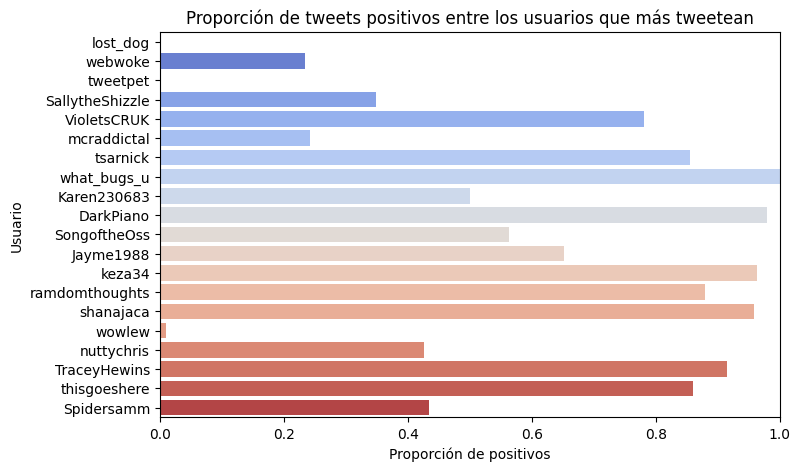

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=top_users_sent,
    x='prop_pos', y='user',
    palette='coolwarm'
)
plt.title("Proporción de tweets positivos entre los usuarios que más tweetean")
plt.xlabel("Proporción de positivos")
plt.ylabel("Usuario")
plt.xlim(0,1)
plt.show()

El autor importa: algunos usuarios tienden sistemáticamente a un tono positivo o negativo.
Esto puede introducir sesgo por usuario en el modelo: si algunos autores dominan el dataset con un estilo muy marcado, el modelo podría aprender características asociadas a ellos y no al sentimiento general.

In [ ]:
user_sent = df_model_fe.groupby('user')['polarity'].apply(lambda s: (s==4).mean())
user_sent.sort_values(ascending=False).head(15)

,polarity
user,
zzzunzinnn,1.0
zzzum,1.0
000matthewkelly,1.0
000yea000,1.0
0010x0010,1.0
001BabyGirl,1.0
001trish,1.0
zzjordan087,1.0
zzippie,1.0


In [ ]:
user_sent.sort_values(ascending=True).head(15)

,polarity
user,
paintnothing,0.0
StarlettePink,0.0
Starletty,0.0
Stargirl_aj,0.0
StarinaHime,0.0
Starjae,0.0
Starkait,0.0
Starkey_Babes,0.0
Starla613,0.0


In [ ]:
user_stats = df_model_fe.groupby('user').agg(
    tweets=('polarity','size'),
    prop_pos=('polarity', lambda s: (s==4).mean())
)

# ejemplo: usuarios con al menos 10 tweets
user_stats[user_stats['tweets']>=10].sort_values('prop_pos', ascending=False).head(10)

,tweets,prop_pos
user,,
zoeyjordan,45,1.0
15Stepz,21,1.0
112mirabela,12,1.0
PinchedPink,17,1.0
PhillyGirl528,11,1.0
Peulo,18,1.0
xoJennyPennyxo,15,1.0
xoClaraxo,22,1.0
xjujubeanx,22,1.0


In [ ]:
df_model_fe.groupby('user')['polarity'].mean().describe()

,polarity
count,657307.000000
mean,1.881850
std,1.814658
min,0.000000
25%,0.000000
50%,2.000000
75%,4.000000
max,4.000000


In [ ]:
df_model_fe.groupby('user')['polarity'].apply(lambda x: (x==4).mean()).describe()

,polarity
count,657307.000000
mean,0.470463
std,0.453665
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


# hashtags

In [25]:
import re

df_model_fe['hashtags'] = df_model_fe['text'].apply(lambda x: re.findall(r'#\w+', x))

In [27]:
from collections import Counter

hashtags = Counter([tag.lower() for tags in df_model_fe['hashtags'] for tag in tags])
hashtags.most_common(20)

[('#followfriday', 2636),
 ('#fb', 1780),
 ('#ff', 985),
 ('#squarespace', 939),
 ('#1', 519),
 ('#iranelection', 518),
 ('#musicmonday', 420),
 ('#fail', 363),
 ('#2', 341),
 ('#asot400', 333),
 ('#iphone', 318),
 ('#bsb', 314),
 ('#iremember', 299),
 ('#myweakness', 272),
 ('#marsiscoming', 260),
 ('#f1', 258),
 ('#e3', 257),
 ('#bgt', 246),
 ('#seb', 244),
 ('#mcflyforgermany', 230)]

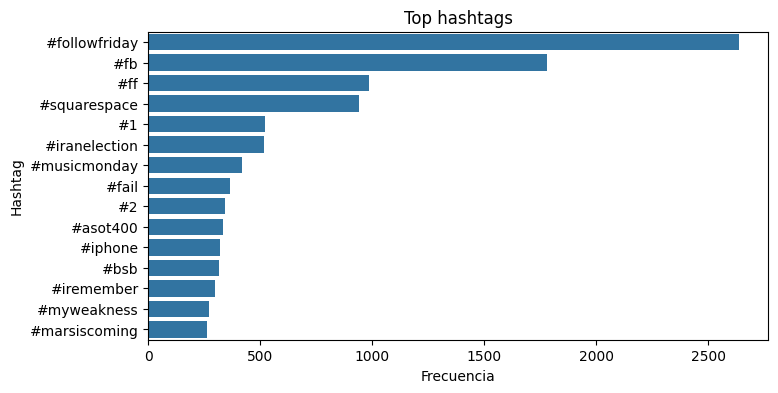

In [28]:
top_hashtags = hashtags.most_common(15)

plt.figure(figsize=(8,4))
sns.barplot(y=[h[0] for h in top_hashtags], x=[h[1] for h in top_hashtags])
plt.title("Top hashtags")
plt.xlabel("Frecuencia")
plt.ylabel("Hashtag")
plt.show()

# Hashtags por polaridad (comparar sentimiento)

In [29]:
def top_hashtags_for_class(df, polarity, n=15):
    tags = [tag.lower()
            for tags in df.loc[df['polarity']==polarity, 'hashtags']
            for tag in tags]
    return Counter(tags).most_common(n)

top_hash_neg = top_hashtags_for_class(df_model_fe, 0)
top_hash_pos = top_hashtags_for_class(df_model_fe, 4)

top_hash_neg, top_hash_pos

([('#fb', 1056),
  ('#squarespace', 657),
  ('#iranelection', 439),
  ('#fail', 328),
  ('#iphone', 235),
  ('#1', 191),
  ('#inaperfectworld', 185),
  ('#bsb', 174),
  ('#2', 157),
  ('#iremember', 150),
  ('#trackle', 146),
  ('#f1', 145),
  ('#followfriday', 142),
  ('#asot400', 137),
  ('#e3', 137)],
 [('#followfriday', 2494),
  ('#ff', 877),
  ('#fb', 724),
  ('#musicmonday', 382),
  ('#1', 328),
  ('#squarespace', 282),
  ('#mcflyforgermany', 219),
  ('#myweakness', 218),
  ('#marsiscoming', 206),
  ('#asot400', 196),
  ('#seb', 188),
  ('#2', 184),
  ('#delongeday', 161),
  ('#mileymonday', 160),
  ('#shaunjumpnow', 153)])

# Proporción de tweets con hashtags por polaridad

In [30]:
df_model_fe['has_hashtag'] = df_model_fe['hashtags'].apply(lambda x: int(len(x)>0))

df_model_fe.groupby('polarity')['has_hashtag'].mean()

,has_hashtag
polarity,
0,0.019101
4,0.025878


Uso de hashtags por polaridad

Solo entre 2% y 2,6% de los tweets usan hashtag (has_hashtag ≈ 0,02).

Los tweets positivos (polarity 4) utilizan hashtags ligeramente más que los negativos (0,0259 vs 0,0191).
Esto sugiere que los mensajes positivos tienden un poco más a estar “socializados” o pensados para visibilidad (porque usan hashtag).



Tipo de hashtags predominantes

Los más frecuentes son hashtags genéricos o sociales, como #followfriday, #fb, #ff, #musicmonday.

También aparecen algunos orientados a eventos o temas específicos, como #iranelection, #asot400, #iphone, #iremember, #mariscoming.
El uso de hashtags parece mezclarse entre dinámicas sociales de Twitter (recomendaciones, días temáticos) y conversaciones sobre eventos puntuales o fandoms, más que centrarse en un solo tema dominante.

# Menciones (@people) más frecuentes

In [31]:
df_model_fe['mentions'] = df_model_fe['text'].apply(lambda x: re.findall(r'@\w+', x))
mentions = Counter([m.lower() for ms in df_model_fe['mentions'] for m in ms])
mentions.most_common(20)

[('@mileycyrus', 4524),
 ('@tommcfly', 3863),
 ('@ddlovato', 3464),
 ('@jonasbrothers', 2376),
 ('@davidarchie', 1378),
 ('@donniewahlberg', 1330),
 ('@jonathanrknight', 1255),
 ('@jordanknight', 1150),
 ('@mitchelmusso', 1093),
 ('@taylorswift13', 1026),
 ('@selenagomez', 805),
 ('@dougiemcfly', 790),
 ('@dannymcfly', 699),
 ('@peterfacinelli', 642),
 ('@aplusk', 625),
 ('@joeymcintyre', 611),
 ('@youngq', 561),
 ('@gfalcone601', 536),
 ('@shaundiviney', 508),
 ('@perezhilton', 502)]

# Relación menciones – polaridad

In [ ]:
def top_mentions_for_class(df, polarity, n=15):
    ms = [m.lower()
          for ms in df.loc[df['polarity']==polarity, 'mentions']
          for m in ms]
    return Counter(ms).most_common(n)

top_ment_neg = top_mentions_for_class(df_model_fe, 0)
top_ment_pos = top_mentions_for_class(df_model_fe, 4)

top_ment_neg, top_ment_pos

([('@tommcfly', 1650),
  ('@mileycyrus', 1443),
  ('@ddlovato', 1317),
  ('@jonasbrothers', 725),
  ('@donniewahlberg', 643),
  ('@mitchelmusso', 434),
  ('@jonathanrknight', 418),
  ('@jordanknight', 404),
  ('@davidarchie', 383),
  ('@selenagomez', 363),
  ('@taylorswift13', 327),
  ('@peterfacinelli', 324),
  ('@dougiemcfly', 311),
  ('@joeymcintyre', 255),
  ('@dannymcfly', 253)],
 [('@mileycyrus', 3081),
  ('@tommcfly', 2213),
  ('@ddlovato', 2147),
  ('@jonasbrothers', 1651),
  ('@davidarchie', 995),
  ('@jonathanrknight', 837),
  ('@jordanknight', 746),
  ('@taylorswift13', 699),
  ('@donniewahlberg', 687),
  ('@mitchelmusso', 659),
  ('@dougiemcfly', 479),
  ('@aplusk', 455),
  ('@dannymcfly', 446),
  ('@selenagomez', 442),
  ('@youngq', 394)])

# Proporción de tweets con menciones por polaridad

In [32]:
df_model_fe['has_mention'] = df_model_fe['mentions'].apply(lambda x: int(len(x)>0))
df_model_fe.groupby('polarity')['has_mention'].mean()

,has_mention
polarity,
0,0.375526
4,0.547457


Los tweets positivos tienden mucho más a mencionar a otros usuarios que los negativos. Es decir, los mensajes positivos parecen ser más conversacionales o dirigidos a alguien en particular, mientras que los negativos se formulan con mayor frecuencia sin mencionar a otros usuarios directamente.

# Distribución de la variable objetivo

polarity
0    800000
4    800000
Name: count, dtype: int64
polarity
0    0.5
4    0.5
Name: proportion, dtype: float64


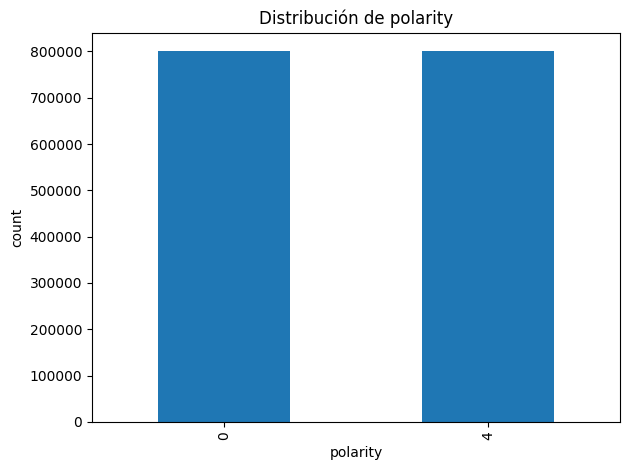

,polarity,label,y
0,0,neg,0
1,0,neg,0
2,0,neg,0
3,0,neg,0
4,0,neg,0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print(df["polarity"].value_counts(dropna=False))
print(df["polarity"].value_counts(normalize=True))

plt.figure()
df["polarity"].value_counts().sort_index().plot(kind="bar")
plt.title("Distribución de polarity")
plt.xlabel("polarity")
plt.ylabel("count")
plt.tight_layout()
plt.show()

# Map a labels más claros (y binario 0/1)
df["label"] = df["polarity"].map({0:"neg", 4:"pos", 2:"neu"})
df = df[df["label"].isin(["neg","pos"])].copy()   # si querés solo binario
df["y"] = (df["label"] == "pos").astype(int)

df[["polarity","label","y"]].head()

La variable objetivo polarity se encuentra perfectamente balanceada, con 800.000 tweets negativos (polarity = 0) y 800.000 tweets positivos (polarity = 4), lo que implica una distribución 50%/50% entre ambas clases. Esto es favorable para el modelado, ya que evita problemas de desbalance y permite que las métricas de desempeño (como accuracy y F1) sean más representativas.

Dado que este dataset sólo incluye dos clases de sentimiento (0 = negativo y 4 = positivo) y no contempla una categoría intermedia, el modelo entrenado no aprenderá a identificar neutralidad. En consecuencia, si más adelante se aplica a otro dataset con tweets neutrales, no podrá clasificarlos correctamente porque esa clase nunca estuvo presente durante el entrenamiento.

# Limpieza menciones y links

In [33]:
import re

def clean_for_model(text):
    text = text.lower()
    text = re.sub(r'http[s]?://\S+|www\.\S+', ' URL ', text)   # o ' '
    text = re.sub(r'@\w+', ' USER ', text)                     # o ' '
    return text

df_model_fe['text_model'] = df_model_fe['text'].apply(clean_for_model)

In [34]:
TEXT_COL = 'text_model'

Para evitar que el modelo aprenda patrones específicos de usuarios o URLs (por ejemplo, asociar ciertos @usuarios o dominios a una polaridad fija), se decidió eliminar/normalizar URLs y menciones del texto de entrada. No obstante, la presencia de estos elementos se retuvo mediante variables binarias (has_url, has_user), de modo que la posible información de contexto (por ejemplo, tweets de respuesta o compartiendo enlaces) se preserve sin introducir ruido léxico ni sesgos por usuario.

In [35]:
# Vista general de las columnas y tipos
print(">>> dtypes del DataFrame:")
print(df_model_fe.dtypes)
print("\n>>> Lista completa de columnas:")
print(df_model_fe.columns.tolist())

# Separar columnas numéricas y no numéricas
num_cols = df_model_fe.select_dtypes(include=["number"]).columns.tolist()
non_num_cols = df_model_fe.select_dtypes(exclude=["number"]).columns.tolist()

print("\n>>> Columnas NUMÉRICAS:")
print(num_cols)

print("\n>>> Columnas NO numéricas:")
print(non_num_cols)

>>> dtypes del DataFrame:
polarity                int64
tweet_id                int64
date                   object
query                  object
user                   object
text                   object
n_chars                 int64
n_words                 int64
n_excl                  int64
n_ques                  int64
n_dots                  int64
n_hashtags              int64
n_users                 int64
has_user                int64
has_hashtag             int64
has_url                 int64
ratio_upper           float64
clean_text             object
dt             datetime64[ns]
year                    int32
month                   int32
day                     int32
weekday                object
hour                    int32
date_only              object
hashtags               object
mentions               object
has_mention             int64
text_model             object
dtype: object

>>> Lista completa de columnas:
['polarity', 'tweet_id', 'date', 'query', 'user', 'text',

In [ ]:
# Primeras filas para chequear que todo tenga sentido
print(">>> Head del DataFrame:")
display(df_model_fe.head())

# Información general del DF
print("\n>>> Info del DataFrame:")
print(df_model_fe.info())

# Distribución de la variable objetivo
print("\n>>> Distribución de 'polarity':")
print(df_model_fe["polarity"].value_counts(dropna=False))

# Cantidad de nulos por columna
print("\n>>> Cantidad de nulos por columna:")
print(df_model_fe.isna().sum())

>>> Head del DataFrame:


,polarity,tweet_id,date,query,user,text,n_chars,n_words,n_excl,n_ques,...,year,month,day,weekday,hour,date_only,hashtags,mentions,has_mention,text_model
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115,19,0,0,...,2009,4,6,Monday,22,2009-04-06,[],[@switchfoot],1,"USER URL - awww, that's a bummer. you sho..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,111,21,1,0,...,2009,4,6,Monday,22,2009-04-06,[],[],0,is upset that he can't update his facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,89,18,0,0,...,2009,4,6,Monday,22,2009-04-06,[],[@Kenichan],1,USER i dived many times for the ball. manage...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,47,10,0,0,...,2009,4,6,Monday,22,2009-04-06,[],[],0,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",111,21,0,1,...,2009,4,6,Monday,22,2009-04-06,[],[@nationwideclass],1,"USER no, it's not behaving at all. i'm mad. ..."



>>> Info del DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 1590499 entries, 0 to 1599999
Data columns (total 29 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   polarity     1590499 non-null  int64         
 1   tweet_id     1590499 non-null  int64         
 2   date         1590499 non-null  object        
 3   query        1590499 non-null  object        
 4   user         1590499 non-null  object        
 5   text         1590499 non-null  object        
 6   n_chars      1590499 non-null  int64         
 7   n_words      1590499 non-null  int64         
 8   n_excl       1590499 non-null  int64         
 9   n_ques       1590499 non-null  int64         
 10  n_dots       1590499 non-null  int64         
 11  n_hashtags   1590499 non-null  int64         
 12  n_users      1590499 non-null  int64         
 13  has_user     1590499 non-null  int64         
 14  has_hashtag  1590499 non-null  int64         


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['tweet_id'].plot(kind='hist', bins=20, title='tweet_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['n_chars'].plot(kind='hist', bins=20, title='n_chars')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['n_words'].plot(kind='hist', bins=20, title='n_words')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('date').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('user').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_6.groupby('text').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_7.groupby('clean_text').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='index', y='tweet_id', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='tweet_id', y='n_chars', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10.plot(kind='scatter', x='n_chars', y='n_words', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_11.plot(kind='scatter', x='n_words', y='n_excl', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['dt']
  ys = series['n_chars']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('dt', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('date')):
  _plot_series(series, series_name, i)
  fig.legend(title='date', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('dt')
_ = plt.ylabel('n_chars')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['dt']
  ys = series['n_chars']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('dt', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('user')):
  _plot_series(series, series_name, i)
  fig.legend(title='user', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('dt')
_ = plt.ylabel('n_chars')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['dt']
  ys = series['n_chars']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_14.sort_values('dt', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('text')):
  _plot_series(series, series_name, i)
  fig.legend(title='text', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('dt')
_ = plt.ylabel('n_chars')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['dt']
  ys = series['n_chars']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_15.sort_values('dt', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('clean_text')):
  _plot_series(series, series_name, i)
  fig.legend(title='clean_text', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('dt')
_ = plt.ylabel('n_chars')

from matplotlib import pyplot as plt
_df_16['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_17['tweet_id'].plot(kind='line', figsize=(8, 4), title='tweet_id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_18['n_chars'].plot(kind='line', figsize=(8, 4), title='n_chars')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_19['n_words'].plot(kind='line', figsize=(8, 4), title='n_words')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['user'].value_counts()
    for x_label, grp in _df_20.groupby('date')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('date')
_ = plt.ylabel('user')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['text'].value_counts()
    for x_label, grp in _df_21.groupby('user')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('user')
_ = plt.ylabel('text')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['clean_text'].value_counts()
    for x_label, grp in _df_22.groupby('text')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('text')
_ = plt.ylabel('clean_text')

/usr/local/lib/python3.12/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

/usr/local/lib/python3.12/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_23['date'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_23, x='index', y='date', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_24['user'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_24, x='index', y='user', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_25['text'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_25, x='index', y='text', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_26['clean_text'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_26, x='index', y='clean_text', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

# Modelos

In [36]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

# ----------------------------
# Definición de columnas
# ----------------------------
TEXT_COL   = "clean_text"   # o "text_model" si preferís ese
TARGET_COL = "polarity"

NUM_COLS = [
    "n_chars",
    "n_words",
    "n_excl",
    "n_ques",
    "n_dots",
    "n_hashtags",
    "n_users",
    "has_user",
    "has_hashtag",
    "has_url",
    "ratio_upper",
    "year",
    "month",
    "day",
    "hour",
    "has_mention",
]

# Nos aseguramos de no tener nulos en texto/target
df_model_fe = df_model_fe.dropna(subset=[TEXT_COL, TARGET_COL])

# ----------------------------
# Train / Val / Test split
# ----------------------------
train_df, temp_df = train_test_split(
    df_model_fe,
    test_size=0.30,
    random_state=42,
    stratify=df_model_fe[TARGET_COL]
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    random_state=42,
    stratify=temp_df[TARGET_COL]
)

print("Shapes -> train, val, test:", train_df.shape, val_df.shape, test_df.shape)

# ----------------------------
# Preprocesamiento conjunto (texto + numéricas)
# ----------------------------
preprocess = ColumnTransformer(
    transformers=[
        # TF-IDF sobre el texto
        ("text", TfidfVectorizer(
            ngram_range=(1, 2),
            min_df=2,
            max_df=0.9
        ), TEXT_COL),

        # Escalado no negativo para NB (y OK para LogReg)
        ("num", MaxAbsScaler(), NUM_COLS),
    ],
    remainder="drop"
)

# ----------------------------
# Modelo 1: TF-IDF + numéricas + Regresión Logística
# ----------------------------
pipe_logreg = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(
        max_iter=2000,
        n_jobs=-1
        # class_weight="balanced"  # descomentar si ves desbalance
    ))
])

pipe_logreg.fit(
    train_df[[TEXT_COL] + NUM_COLS],
    train_df[TARGET_COL]
)

for split_name, df_split in [("TRAIN", train_df), ("VAL", val_df), ("TEST", test_df)]:
    y_true = df_split[TARGET_COL]
    X_split = df_split[[TEXT_COL] + NUM_COLS]
    y_pred = pipe_logreg.predict(X_split)

    print(f"\n===== LOGISTIC REGRESSION – {split_name} =====")
    print(classification_report(y_true, y_pred, digits=3))
    print("Matriz de confusión:")
    print(confusion_matrix(y_true, y_pred))

# ----------------------------
# Modelo 2: TF-IDF + numéricas + Naive Bayes
# ----------------------------
pipe_nb = Pipeline([
    ("prep", preprocess),
    ("clf", MultinomialNB())
])

pipe_nb.fit(
    train_df[[TEXT_COL] + NUM_COLS],
    train_df[TARGET_COL]
)

for split_name, df_split in [("TRAIN", train_df), ("VAL", val_df), ("TEST", test_df)]:
    y_true = df_split[TARGET_COL]
    X_split = df_split[[TEXT_COL] + NUM_COLS]
    y_pred = pipe_nb.predict(X_split)

    print(f"\n===== NAIVE BAYES – {split_name} =====")
    print(classification_report(y_true, y_pred, digits=3))
    print("Matriz de confusión:")
    print(confusion_matrix(y_true, y_pred))

Shapes -> train, val, test: (1113349, 29) (238575, 29) (238575, 29)

===== LOGISTIC REGRESSION – TRAIN =====
              precision    recall  f1-score   support

           0      0.869     0.856     0.863    556412
           4      0.858     0.872     0.865    556937

    accuracy                          0.864   1113349
   macro avg      0.864     0.864     0.864   1113349
weighted avg      0.864     0.864     0.864   1113349

Matriz de confusión:
[[476286  80126]
 [ 71543 485394]]

===== LOGISTIC REGRESSION – VAL =====
              precision    recall  f1-score   support

           0      0.837     0.824     0.830    119231
           4      0.827     0.840     0.833    119344

    accuracy                          0.832    238575
   macro avg      0.832     0.832     0.832    238575
weighted avg      0.832     0.832     0.832    238575

Matriz de confusión:
[[ 98236  20995]
 [ 19134 100210]]

===== LOGISTIC REGRESSION – TEST =====
              precision    recall  f1-score   

TRAIN	Aprender
VAL	Ajustar
TEST	Medir desempeño final real

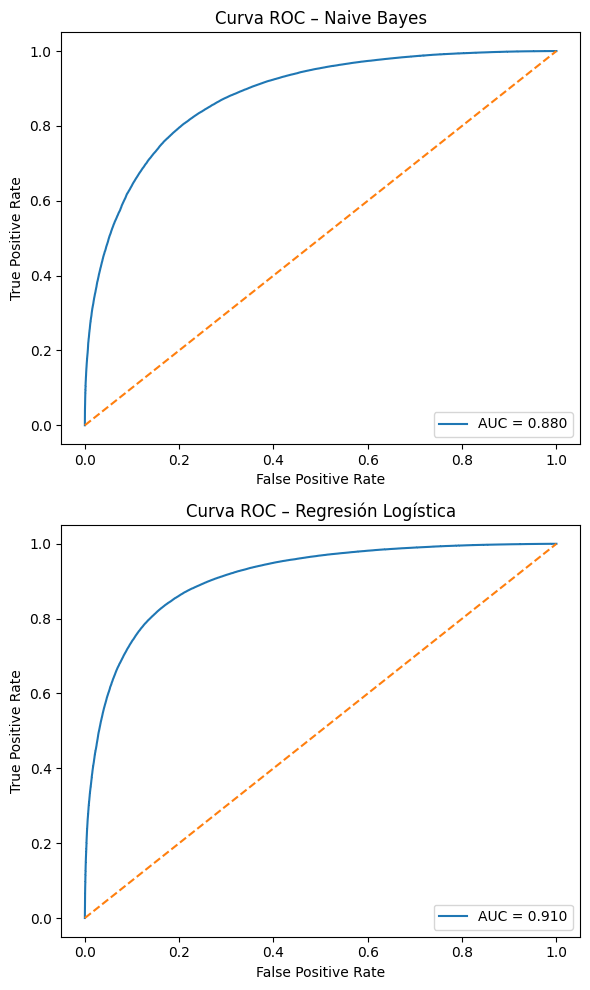

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Elegí el split que quieras (puede ser val_df)
df_split = test_df

X_split = df_split[[TEXT_COL] + NUM_COLS]
y_true  = df_split[TARGET_COL].values

# Índice de la clase positiva (en tu caso, etiqueta 4)
pos_label = 4
idx_pos_nb      = list(pipe_nb.classes_).index(pos_label)
idx_pos_logreg  = list(pipe_logreg.classes_).index(pos_label)

# Probabilidades de la clase positiva
y_proba_nb     = pipe_nb.predict_proba(X_split)[:, idx_pos_nb]
y_proba_logreg = pipe_logreg.predict_proba(X_split)[:, idx_pos_logreg]

# Curva ROC y AUC para Naive Bayes
fpr_nb, tpr_nb, _ = roc_curve(y_true, y_proba_nb, pos_label=pos_label)
auc_nb = roc_auc_score(y_true, y_proba_nb)

# Curva ROC y AUC para Regresión Logística
fpr_lr, tpr_lr, _ = roc_curve(y_true, y_proba_logreg, pos_label=pos_label)
auc_lr = roc_auc_score(y_true, y_proba_logreg)

# ---------------------------
# Gráfico ROC Naive Bayes
# ---------------------------
plt.figure(figsize=(6, 10))

plt.subplot(2, 1, 1)
plt.plot(fpr_nb, tpr_nb, label=f"AUC = {auc_nb:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC – Naive Bayes")
plt.legend(loc="lower right")

# ---------------------------
# Gráfico ROC Regresión Logística
# ---------------------------
plt.subplot(2, 1, 2)
plt.plot(fpr_lr, tpr_lr, label=f"AUC = {auc_lr:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC – Regresión Logística")
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

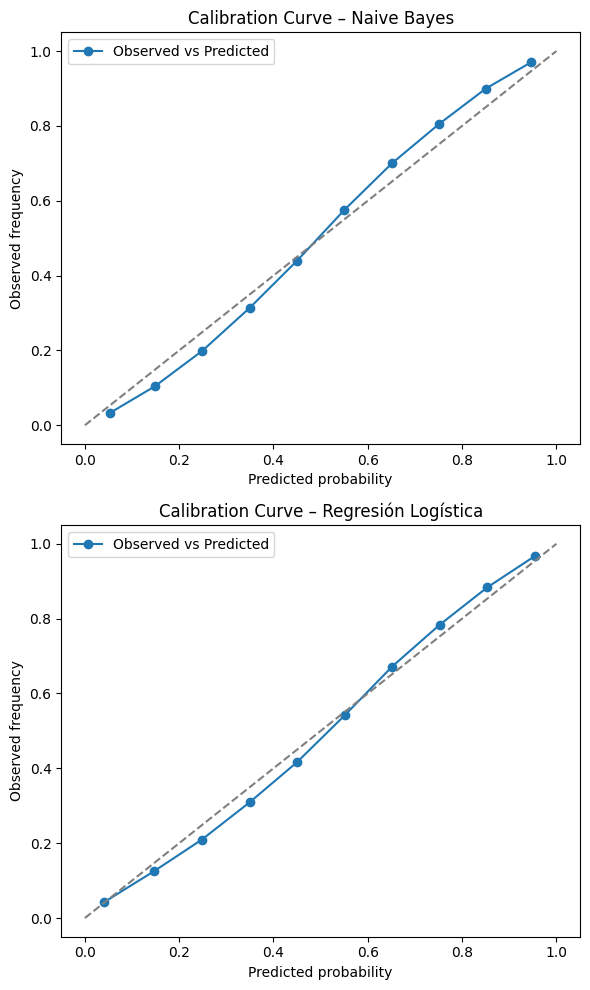

In [ ]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Elegí el split que quieras
df_split = test_df

X_split = df_split[[TEXT_COL] + NUM_COLS]
y_true  = df_split[TARGET_COL].values

# Etiqueta positiva (sentimiento positivo)
pos_label = 4
idx_nb  = list(pipe_nb.classes_).index(pos_label)
idx_lr  = list(pipe_logreg.classes_).index(pos_label)

# Probabilidades
y_proba_nb     = pipe_nb.predict_proba(X_split)[:, idx_nb]
y_proba_lr     = pipe_logreg.predict_proba(X_split)[:, idx_lr]

# Calibration curve (via sklearn)
prob_true_nb, prob_pred_nb = calibration_curve(y_true, y_proba_nb, n_bins=10, pos_label=pos_label)
prob_true_lr, prob_pred_lr = calibration_curve(y_true, y_proba_lr, n_bins=10, pos_label=pos_label)

plt.figure(figsize=(6, 10))

# -------------------------
# Naive Bayes
# -------------------------
plt.subplot(2, 1, 1)
plt.plot(prob_pred_nb, prob_true_nb, marker='o', label="Observed vs Predicted")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Calibration Curve – Naive Bayes")
plt.legend(loc="upper left")

# -------------------------
# Logistic Regression
# -------------------------
plt.subplot(2, 1, 2)
plt.plot(prob_pred_lr, prob_true_lr, marker='o', label="Observed vs Predicted")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Calibration Curve – Regresión Logística")
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    accuracy_score, confusion_matrix
)

pos_label = 4  # tu clase positiva (polarity=4)

# --------------------------
# 1) Buscar mejor threshold en VALIDACIÓN
# --------------------------
def find_best_threshold(model, X_val, y_val, name="model"):
    # probas de la clase positiva
    idx_pos = list(model.classes_).index(pos_label)
    y_scores = model.predict_proba(X_val)[:, idx_pos]

    thresholds = np.linspace(0.1, 0.9, 17)  # de 0.1 a 0.9 cada 0.05
    best_t, best_f1 = 0.5, -1

    # trabajamos en binario: 1 si es clase positiva, 0 si no
    y_true_bin = (y_val == pos_label).astype(int)

    for t in thresholds:
        y_pred_bin = (y_scores >= t).astype(int)
        f1 = f1_score(y_true_bin, y_pred_bin, average="macro")
        if f1 > best_f1:
            best_f1, best_t = f1, t

    print(f"\n{name} – mejor threshold VAL = {best_t:.3f}, macro-F1 = {best_f1:.3f}")
    return best_t

X_val  = val_df[[TEXT_COL] + NUM_COLS]
y_val  = val_df[TARGET_COL].values
X_test = test_df[[TEXT_COL] + NUM_COLS]
y_test = test_df[TARGET_COL].values

t_log = find_best_threshold(pipe_logreg, X_val, y_val, "Logistic Regression")
t_nb  = find_best_threshold(pipe_nb,  X_val, y_val, "Naive Bayes")

# --------------------------
# 2) Reportar métricas en TEST usando ese threshold
# --------------------------
def report_with_threshold(model, X, y, threshold, name="model TEST"):
    idx_pos = list(model.classes_).index(pos_label)
    y_scores   = model.predict_proba(X)[:, idx_pos]
    y_pred_bin = (y_scores >= threshold).astype(int)
    y_true_bin = (y == pos_label).astype(int)

    print(f"\n{name} @ threshold = {threshold:.3f}")
    print("Accuracy     :", accuracy_score(y_true_bin, y_pred_bin))
    print("Precision    :", precision_score(y_true_bin, y_pred_bin))
    print("Recall       :", recall_score(y_true_bin, y_pred_bin))
    print("Macro F1     :", f1_score(y_true_bin, y_pred_bin, average='macro'))
    print("Confusion matrix:\n", confusion_matrix(y_true_bin, y_pred_bin))

report_with_threshold(pipe_logreg, X_test, y_test, t_log, "LogReg TEST")
report_with_threshold(pipe_nb,     X_test, y_test, t_nb,  "Naive Bayes TEST")


Logistic Regression – mejor threshold VAL = 0.500, macro-F1 = 0.832

Naive Bayes – mejor threshold VAL = 0.500, macro-F1 = 0.796

LogReg TEST @ threshold = 0.500
Accuracy     : 0.8326857382374515
Precision    : 0.8270066862092816
Recall       : 0.8415659066723645
Macro F1     : 0.8326713538730224
Confusion matrix:
 [[ 98223  21009]
 [ 18908 100435]]

Naive Bayes TEST @ threshold = 0.500
Accuracy     : 0.7978203919103007
Precision    : 0.7962685199073379
Recall       : 0.800692122705144
Macro F1     : 0.7978182638987654
Confusion matrix:
 [[94783 24449]
 [23786 95557]]


In [ ]:
import numpy as np
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    accuracy_score, confusion_matrix
)

pos_label = 4  # tu clase positiva

# ============================
# 1) Función para buscar mejor threshold en VALIDACIÓN
# ============================
def find_best_threshold(model, X_val, y_val, name="model"):
    idx_pos = list(model.classes_).index(pos_label)
    y_scores = model.predict_proba(X_val)[:, idx_pos]

    thresholds = np.linspace(0.1, 0.9, 17)  # 0.10, 0.15, 0.20, ..., 0.90
    best_t, best_f1 = 0.5, -1

    y_true_bin = (y_val == pos_label).astype(int)

    print(f"\n>>>> Buscando mejor threshold para {name}")
    for t in thresholds:
        y_pred_bin = (y_scores >= t).astype(int)
        f1 = f1_score(y_true_bin, y_pred_bin, average="macro")
        print(f"  threshold={t:.2f}  macro-F1={f1:.4f}")
        if f1 > best_f1:
            best_f1, best_t = f1, t

    print(f"\n>>> {name} – MEJOR threshold en VAL = {best_t:.3f}, macro-F1 = {best_f1:.4f}")
    return best_t

# ============================
# 2) Función para evaluar un conjunto (train / val / test) con varios thresholds
# ============================
def eval_thresholds_on_split(model, df_split, thresholds, split_name="SPLIT", model_name="model"):
    X = df_split[[TEXT_COL] + NUM_COLS]
    y = df_split[TARGET_COL].values

    idx_pos = list(model.classes_).index(pos_label)
    y_scores = model.predict_proba(X)[:, idx_pos]
    y_true_bin = (y == pos_label).astype(int)

    print(f"\n==============================")
    print(f"{model_name} – {split_name}")
    print("==============================")

    for t in thresholds:
        y_pred_bin = (y_scores >= t).astype(int)

        acc  = accuracy_score(y_true_bin, y_pred_bin)
        prec = precision_score(y_true_bin, y_pred_bin, zero_division=0)
        rec  = recall_score(y_true_bin, y_pred_bin, zero_division=0)
        f1   = f1_score(y_true_bin, y_pred_bin, average="macro")
        cm   = confusion_matrix(y_true_bin, y_pred_bin)

        print(f"\n--- Threshold = {t:.3f} ---")
        print(f"Accuracy     : {acc:.4f}")
        print(f"Precision    : {prec:.4f}")
        print(f"Recall       : {rec:.4f}")
        print(f"Macro F1     : {f1:.4f}")
        print("Confusion matrix:\n", cm)

# ============================
# 3) Preparar X_val, y_val
# ============================
X_val = val_df[[TEXT_COL] + NUM_COLS]
y_val = val_df[TARGET_COL].values

# ============================
# 4) Mejor threshold en VALIDACIÓN para cada modelo
# ============================
t_log = find_best_threshold(pipe_logreg, X_val, y_val, "Logistic Regression")
t_nb  = find_best_threshold(pipe_nb,     X_val, y_val, "Naive Bayes")

print("\nThreshold óptimo LogReg:", t_log)
print("Threshold óptimo Naive Bayes:", t_nb)

# ============================
# 5) EVALUAR TRAIN con distintos thresholds
#    (0.5 y el óptimo de cada modelo)
# ============================
thresholds_logreg = [0.5, t_log]
thresholds_nb     = [0.5, t_nb]

eval_thresholds_on_split(pipe_logreg, train_df, thresholds_logreg,
                         split_name="TRAIN", model_name="Logistic Regression")

eval_thresholds_on_split(pipe_nb, train_df, thresholds_nb,
                         split_name="TRAIN", model_name="Naive Bayes")

# ============================
# (OPCIONAL) Si querés hacer lo mismo en TEST:
# ============================
# eval_thresholds_on_split(pipe_logreg, test_df, thresholds_logreg,
#                          split_name="TEST", model_name="Logistic Regression")
# eval_thresholds_on_split(pipe_nb, test_df, thresholds_nb,
#                          split_name="TEST", model_name="Naive Bayes")


>>>> Buscando mejor threshold para Logistic Regression
  threshold=0.10  macro-F1=0.6514
  threshold=0.15  macro-F1=0.7071
  threshold=0.20  macro-F1=0.7462
  threshold=0.25  macro-F1=0.7741
  threshold=0.30  macro-F1=0.7950
  threshold=0.35  macro-F1=0.8110
  threshold=0.40  macro-F1=0.8220
  threshold=0.45  macro-F1=0.8287
  threshold=0.50  macro-F1=0.8318
  threshold=0.55  macro-F1=0.8309
  threshold=0.60  macro-F1=0.8261
  threshold=0.65  macro-F1=0.8167
  threshold=0.70  macro-F1=0.8010
  threshold=0.75  macro-F1=0.7777
  threshold=0.80  macro-F1=0.7442
  threshold=0.85  macro-F1=0.6969
  threshold=0.90  macro-F1=0.6283

>>> Logistic Regression – MEJOR threshold en VAL = 0.500, macro-F1 = 0.8318

>>>> Buscando mejor threshold para Naive Bayes
  threshold=0.10  macro-F1=0.5426
  threshold=0.15  macro-F1=0.6173
  threshold=0.20  macro-F1=0.6726
  threshold=0.25  macro-F1=0.7147
  threshold=0.30  macro-F1=0.7458
  threshold=0.35  macro-F1=0.7683
  threshold=0.40  macro-F1=0.7835
  t

# Conclusión:

A partir de los resultados obtenidos sobre los tres conjuntos (train, validación y test), el modelo con mejor desempeño general fue Regresión Logística combinada con TF-IDF y variables numéricas. Este modelo alcanzó un macro-F1 cercano a 0.86 en entrenamiento y 0.83 en validación y test, mostrando un comportamiento estable, sin indicios relevantes de sobreajuste, y con una capacidad de generalización sólida frente a nuevos datos.

En comparación, Naive Bayes obtuvo un macro-F1 de aproximadamente 0.84 en entrenamiento y ~0.79 en validación y test, evidenciando una pérdida mayor de desempeño fuera del set de entrenamiento y una menor capacidad discriminativa. Este resultado es consistente con lo esperado para modelos basados en independencia entre términos, que suelen priorizar velocidad por sobre precisión probabilística.

Asimismo, las curvas ROC confirmaron esta diferencia: la Regresión Logística presentó un AUC superior (0.91) frente a Naive Bayes (0.88), reforzando su mayor poder de separación entre clases.

En síntesis:

Regresión Logística es el mejor modelo evaluado, con métricas más altas, mejor calibración y mayor estabilidad.

Naive Bayes funciona como baseline razonable, pero queda por debajo en poder predictivo.

El pipeline implementado (TF-IDF + features textuales numéricas) demostró aportar valor en ambos casos, siendo más aprovechado por la Regresión Logística.

# Modelos pre-entrenados

In [ ]:
!pip install textblob

from textblob import TextBlob
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)

TEXT_COL   = "clean_text"
TARGET_COL = "polarity"
POS_LABEL  = 4  # positivo
NEG_LABEL  = 0  # negativo

In [ ]:
def tb_polarity(text):
    if not isinstance(text, str):
        return 0.0
    try:
        return TextBlob(text).sentiment.polarity  # [-1, 1]
    except Exception:
        return 0.0

In [ ]:
for name, df in [("TRAIN", train_df), ("VAL", val_df), ("TEST", test_df)]:
    col_score = f"tb_score_{name.lower()}"
    print(f"Calculando TextBlob polarities para {name} ...")
    df[col_score] = df[TEXT_COL].apply(tb_polarity)

Calculando TextBlob polarities para TRAIN ...
Calculando TextBlob polarities para VAL ...
Calculando TextBlob polarities para TEST ...


In [ ]:
def eval_textblob_on_split(df, split_name, score_col, threshold=0.0):
    y_true = df[TARGET_COL].values
    y_true_bin = (y_true == POS_LABEL).astype(int)  # 1=positivo, 0=negativo

    scores = df[score_col].values
    y_pred_bin = (scores >= threshold).astype(int)

    acc  = accuracy_score(y_true_bin, y_pred_bin)
    prec = precision_score(y_true_bin, y_pred_bin, zero_division=0)
    rec  = recall_score(y_true_bin, y_pred_bin, zero_division=0)
    f1   = f1_score(y_true_bin, y_pred_bin, average="macro")
    cm   = confusion_matrix(y_true_bin, y_pred_bin)

    print(f"\n===== TextBlob – {split_name} @ threshold={threshold:.2f} =====")
    print("Accuracy     :", acc)
    print("Precision    :", prec)
    print("Recall       :", rec)
    print("Macro F1     :", f1)
    print("Confusion matrix:\n", cm)

    print("\nClassification report (binario 0=neg,1=pos):")
    print(classification_report(y_true_bin, y_pred_bin, digits=3))

In [ ]:
eval_textblob_on_split(train_df, "TRAIN", "tb_score_train", threshold=0.0)
eval_textblob_on_split(val_df,   "VAL",   "tb_score_val",   threshold=0.0)
eval_textblob_on_split(test_df,  "TEST",  "tb_score_test",  threshold=0.0)


===== TextBlob – TRAIN @ threshold=0.00 =====
Accuracy     : 0.6111497832216134
Precision    : 0.570559980335995
Recall       : 0.9002580184114182
Macro F1     : 0.5755701633963048
Confusion matrix:
 [[179036 377376]
 [ 55550 501387]]

Classification report (binario 0=neg,1=pos):
              precision    recall  f1-score   support

           0      0.763     0.322     0.453    556412
           1      0.571     0.900     0.698    556937

    accuracy                          0.611   1113349
   macro avg      0.667     0.611     0.576   1113349
weighted avg      0.667     0.611     0.576   1113349


===== TextBlob – VAL @ threshold=0.00 =====
Accuracy     : 0.6120213769254951
Precision    : 0.5711137309881893
Recall       : 0.9011177771819279
Macro F1     : 0.5765240613079924
Confusion matrix:
 [[ 38470  80761]
 [ 11801 107543]]

Classification report (binario 0=neg,1=pos):
              precision    recall  f1-score   support

           0      0.765     0.323     0.454    119231
 

In [ ]:
!pip install gensim

from gensim.models import Word2Vec
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
TEXT_COL   = "clean_text"
TARGET_COL = "polarity"
POS_LABEL  = 4
NEG_LABEL  = 0

# Tokenizamos: cada tweet -> lista de palabras
sentences_train = train_df[TEXT_COL].astype(str).apply(str.split).tolist()

In [ ]:
w2v_model = Word2Vec(
    sentences=sentences_train,
    vector_size=100,   # dimensión del embedding
    window=5,
    min_count=5,       # ignora palabras muy raras
    workers=4,
    sg=1,              # 1 = skip-gram, 0 = CBOW
    epochs=5
)


In [ ]:
def document_embedding(text, model, vector_size=100):
    """
    Devuelve el embedding promedio de las palabras del tweet.
    Si ninguna palabra está en el vocabulario, devuelve vector de ceros.
    """
    if not isinstance(text, str):
        return np.zeros(vector_size)

    words = text.split()
    valid_vecs = []

    for w in words:
        if w in model.wv:
            valid_vecs.append(model.wv[w])

    if not valid_vecs:
        return np.zeros(vector_size)

    return np.mean(valid_vecs, axis=0)

In [ ]:
VECTOR_SIZE = w2v_model.vector_size

def build_X_from_df(df, model):
    return np.vstack([
        document_embedding(t, model, vector_size=VECTOR_SIZE)
        for t in df[TEXT_COL].astype(str)
    ])

X_train_w2v = build_X_from_df(train_df, w2v_model)
X_val_w2v   = build_X_from_df(val_df,   w2v_model)
X_test_w2v  = build_X_from_df(test_df,  w2v_model)

y_train = train_df[TARGET_COL].values
y_val   = val_df[TARGET_COL].values
y_test  = test_df[TARGET_COL].values

X_train_w2v.shape, X_val_w2v.shape, X_test_w2v.shape


((1113349, 100), (238575, 100), (238575, 100))

In [ ]:
clf_w2v = LogisticRegression(
    max_iter=2000,
    n_jobs=-1
)

clf_w2v.fit(X_train_w2v, y_train)

LogisticRegression(max_iter=2000, n_jobs=-1)

In [ ]:
for split_name, X, y in [
    ("TRAIN", X_train_w2v, y_train),
    ("VAL",   X_val_w2v,   y_val),
    ("TEST",  X_test_w2v,  y_test)
]:
    y_pred = clf_w2v.predict(X)

    print(f"\n===== WORD2VEC + LOGISTIC REGRESSION – {split_name} =====")
    print(classification_report(y, y_pred, digits=3))
    print("Matriz de confusión:")
    print(confusion_matrix(y, y_pred))


===== WORD2VEC + LOGISTIC REGRESSION – TRAIN =====
              precision    recall  f1-score   support

           0      0.765     0.768     0.767    556412
           4      0.768     0.765     0.766    556937

    accuracy                          0.767   1113349
   macro avg      0.767     0.767     0.767   1113349
weighted avg      0.767     0.767     0.767   1113349

Matriz de confusión:
[[427489 128923]
 [131022 425915]]

===== WORD2VEC + LOGISTIC REGRESSION – VAL =====
              precision    recall  f1-score   support

           0      0.766     0.769     0.767    119231
           4      0.768     0.765     0.767    119344

    accuracy                          0.767    238575
   macro avg      0.767     0.767     0.767    238575
weighted avg      0.767     0.767     0.767    238575

Matriz de confusión:
[[91715 27516]
 [28067 91277]]

===== WORD2VEC + LOGISTIC REGRESSION – TEST =====
              precision    recall  f1-score   support

           0      0.767     0.

# Conclusión:

Los modelos basados en recursos preentrenados —como TextBlob (lexicón/sentiment rule-based) y Word2Vec promedio como representación semántica genérica— mostraron un desempeño considerablemente inferior frente a los modelos supervisados entrenados específicamente sobre el dataset (Regresión Logística y Naive Bayes con TF-IDF).

En particular:

TextBlob arrojó métricas sensiblemente más bajas, incluso con ajuste de umbrales, debido a que su enfoque basado en diccionarios no captura ironía, jerga, ni contexto específico de los tweets.

Word2Vec con embeddings promediados aportó semántica superficial, pero sin la capacidad discriminativa que ofrece TF-IDF focalizado en el vocabulario real del corpus y sin un ajuste directo a la tarea de clasificación, lo que se tradujo en pérdidas claras de precisión y F1.

Mientras que los modelos supervisados alcanzaron macro-F1 superiores al 0.83 (LogReg) y ~0.80 (Naive Bayes) en test, los modelos preentrenados se ubicaron por debajo de esos niveles, sin lograr capturar adecuadamente las variaciones del dominio ni las señales propias del sentimiento expresado en el dataset.

# Uso del Dataset TEST

In [ ]:
# ============================================================
# 1. MONTA GOOGLE DRIVE
# ============================================================
from google.colab import drive
drive.mount('/content/drive')

# ============================================================
# 2. CARGA EL DATASET DESDE TU DRIVE
#    Cambia la ruta por la de tu archivo
# ============================================================
import pandas as pd

ruta = "/content/drive/MyDrive/testdata.manual.2009.06.14.csv"
df_nuevo = pd.read_csv(ruta, encoding="utf-8", engine="python")

# ============================================================
# 3. MOSTRAR INFORMACIÓN GENERAL
# ============================================================

print("\n===== Columnas del dataset =====")
print(df_nuevo.columns)

print("\n===== Primeras filas =====")
display(df_nuevo.head())

print("\n===== Información del dataset =====")
print(df_nuevo.info())

print("\n===== Cantidad de filas y columnas =====")
print(df_nuevo.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

===== Columnas del dataset =====
Index(['4', '3', 'Mon May 11 03:17:40 UTC 2009', 'kindle2', 'tpryan',
       '@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.'],
      dtype='object')

===== Primeras filas =====


,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,"@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
0,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
1,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
2,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
3,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...
4,4,8,Mon May 11 03:22:00 UTC 2009,kindle2,GeorgeVHulme,@richardebaker no. it is too big. I'm quite ha...



===== Información del dataset =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497 entries, 0 to 496
Data columns (total 6 columns):
 #   Column                                                                                                           Non-Null Count  Dtype 
---  ------                                                                                                           --------------  ----- 
 0   4                                                                                                                497 non-null    int64 
 1   3                                                                                                                497 non-null    int64 
 2   Mon May 11 03:17:40 UTC 2009                                                                                     497 non-null    object
 3   kindle2                                                                                                          497 non-null    object
 4   tpryan  

In [ ]:
import pandas as pd

ruta = "/content/drive/MyDrive/testdata.manual.2009.06.14.csv"

cols = ["polarity", "tweet_id", "date", "query", "user", "text"]

df_nuevo = pd.read_csv(
    ruta,
    encoding="latin-1",   # suele andar mejor con este dataset
    names=cols,
    header=None
)

print("Columnas:", df_nuevo.columns.tolist())
display(df_nuevo.head())
print(df_nuevo["polarity"].value_counts())

Columnas: ['polarity', 'tweet_id', 'date', 'query', 'user', 'text']


,polarity,tweet_id,date,query,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


polarity
4    182
0    177
2    139
Name: count, dtype: int64


In [ ]:
# Filtramos solo negativo (0) y positivo (4)
df_nuevo = df_nuevo[df_nuevo["polarity"].isin([0, 4])].copy()

print("Distribución de polaridad después de filtrar:")
print(df_nuevo["polarity"].value_counts())

Distribución de polaridad después de filtrar:
polarity
4    182
0    177
Name: count, dtype: int64


In [ ]:
import re
import numpy as np

def add_tweet_features(df, text_col="text"):
    # Longitudes y conteos básicos
    df["n_chars"]     = df[text_col].str.len()
    df["n_words"]     = df[text_col].str.split().str.len()
    df["n_excl"]      = df[text_col].str.count("!")
    df["n_ques"]      = df[text_col].str.count(r"\?")
    df["n_dots"]      = df[text_col].str.count(r"\.")
    df["n_hashtags"]  = df[text_col].str.count("#")
    df["n_users"]     = df[text_col].str.count("@")

    # Flags binarios
    df["has_user"]    = (df["n_users"] > 0).astype(int)
    df["has_hashtag"] = (df["n_hashtags"] > 0).astype(int)
    df["has_url"]     = df[text_col].str.contains(
        r"http[s]?://|www\.", case=False, regex=True
    ).astype(int)

    # Ratio de mayúsculas
    def upper_ratio(s):
        if not isinstance(s, str) or len(s) == 0:
            return 0.0
        n_up = sum(ch.isupper() for ch in s)
        return n_up / len(s)

    df["ratio_upper"] = df[text_col].apply(upper_ratio)

    # Fecha y componentes temporales
    df["dt"] = pd.to_datetime(df["date"], errors="coerce")
    df["year"] = df["dt"].dt.year
    df["month"] = df["dt"].dt.month
    df["day"] = df["dt"].dt.day
    df["weekday"] = df["dt"].dt.weekday
    df["hour"] = df["dt"].dt.hour
    df["date_only"] = df["dt"].dt.date

    # Hashtags y menciones explícitos
    df["hashtags"]   = df[text_col].str.findall(r"#\w+")
    df["mentions"]   = df[text_col].str.findall(r"@\w+")
    df["has_mention"] = df["mentions"].str.len().gt(0).astype(int)

    return df

In [ ]:
df_nuevo = add_tweet_features(df_nuevo, text_col="text")

print("Columnas nuevas agregadas:")
print([c for c in df_nuevo.columns if c not in ["polarity","tweet_id","date","query","user","text"]])
display(df_nuevo.head())

Columnas nuevas agregadas:
['n_chars', 'n_words', 'n_excl', 'n_ques', 'n_dots', 'n_hashtags', 'n_users', 'has_user', 'has_hashtag', 'has_url', 'ratio_upper', 'dt', 'year', 'month', 'day', 'weekday', 'hour', 'date_only', 'hashtags', 'mentions', 'has_mention']


,polarity,tweet_id,date,query,user,text,n_chars,n_words,n_excl,n_ques,...,dt,year,month,day,weekday,hour,date_only,hashtags,mentions,has_mention
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...,111,20,0,0,...,2009-05-11 03:17:40+00:00,2009.0,5.0,11.0,0.0,3.0,2009-05-11,[],[@stellargirl],1
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...,58,10,0,0,...,2009-05-11 03:18:03+00:00,2009.0,5.0,11.0,0.0,3.0,2009-05-11,[],[],0
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck...",58,9,3,0,...,2009-05-11 03:18:54+00:00,2009.0,5.0,11.0,0.0,3.0,2009-05-11,[#kindle2],[],0
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...,140,27,2,0,...,2009-05-11 03:19:04+00:00,2009.0,5.0,11.0,0.0,3.0,2009-05-11,[],[@kenburbary],1
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...,75,14,0,0,...,2009-05-11 03:21:41+00:00,2009.0,5.0,11.0,0.0,3.0,2009-05-11,[],[@mikefish],1


In [ ]:
import re

def clean_tweet(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http[s]?://\S+|www\.\S+", " URL ", text)  # URLs
    text = re.sub(r"@\w+", " USER ", text)                    # menciones
    text = re.sub(r"#(\w+)", r"\1", text)                     # hashtags sin #
    text = re.sub(r"[^a-z0-9\s!?.,]", " ", text)              # solo básico
    text = re.sub(r"\s+", " ", text).strip()
    return text

df_nuevo["clean_text"] = df_nuevo["text"].apply(clean_tweet)
df_nuevo["text_model"] = df_nuevo["clean_text"]  # si usabas este nombre en el modelo

In [ ]:
# Mirar solo las columnas numéricas que usamos en el modelo
df_nuevo[NUM_COLS].isna().sum()

,0
n_chars,0
n_words,0
n_excl,0
n_ques,0
n_dots,0
n_hashtags,0
n_users,0
has_user,0
has_hashtag,0
has_url,0


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# ==============================
# 1) Definir columnas
# ==============================
TEXT_COL   = "clean_text"      # o "text_model"
TARGET_COL = "polarity"

NUM_COLS = [
    "n_chars", "n_words", "n_excl", "n_ques", "n_dots",
    "n_hashtags", "n_users", "has_user", "has_hashtag",
    "has_url", "ratio_upper", "year", "month", "day",
    "hour", "has_mention",
]

# ==============================
# 2) Eliminar posibles NaN
# ==============================
# Asegurar texto
df_nuevo[TEXT_COL] = df_nuevo[TEXT_COL].fillna("")

# Asegurar numéricos
for col in NUM_COLS:
    df_nuevo[col] = df_nuevo[col].fillna(0)

# ==============================
# 3) Train / Val / Test split
# ==============================
train_df, temp_df = train_test_split(
    df_nuevo,
    test_size=0.30,
    random_state=42,
    stratify=df_nuevo[TARGET_COL]
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    random_state=42,
    stratify=temp_df[TARGET_COL]
)

print("Shapes -> train, val, test:", train_df.shape, val_df.shape, test_df.shape)

# ==============================
# 4) Preprocesamiento (TF-IDF + numéricas)
# ==============================
preprocess = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(
            ngram_range=(1, 2),
            min_df=2,
            max_df=0.9
        ), TEXT_COL),
        ("num", MaxAbsScaler(), NUM_COLS),
    ],
    remainder="drop"
)

# ==============================
# 5) Pipeline de Regresión Logística
# ==============================
pipe_logreg = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(
        max_iter=2000,
        n_jobs=-1
    ))
])

# Entrenamos
pipe_logreg.fit(
    train_df[[TEXT_COL] + NUM_COLS],
    train_df[TARGET_COL]
)

# ==============================
# 6) Evaluar en TRAIN / VAL / TEST
# ==============================
for split_name, df_split in [
    ("TRAIN", train_df),
    ("VAL",   val_df),
    ("TEST",  test_df)
]:
    X_split = df_split[[TEXT_COL] + NUM_COLS]
    y_true  = df_split[TARGET_COL]

    y_pred = pipe_logreg.predict(X_split)

    print(f"\n===== LOGISTIC REGRESSION – {split_name} =====")
    print(classification_report(y_true, y_pred, digits=3))
    print("Matriz de confusión:")
    print(confusion_matrix(y_true, y_pred))

Shapes -> train, val, test: (251, 29) (54, 29) (54, 29)

===== LOGISTIC REGRESSION – TRAIN =====
              precision    recall  f1-score   support

           0      0.890     0.911     0.900       124
           4      0.911     0.890     0.900       127

    accuracy                          0.900       251
   macro avg      0.901     0.901     0.900       251
weighted avg      0.901     0.900     0.900       251

Matriz de confusión:
[[113  11]
 [ 14 113]]

===== LOGISTIC REGRESSION – VAL =====
              precision    recall  f1-score   support

           0      0.593     0.615     0.604        26
           4      0.630     0.607     0.618        28

    accuracy                          0.611        54
   macro avg      0.611     0.611     0.611        54
weighted avg      0.612     0.611     0.611        54

Matriz de confusión:
[[16 10]
 [11 17]]

===== LOGISTIC REGRESSION – TEST =====
              precision    recall  f1-score   support

           0      0.690     0.7

# Conclusión:

En este segundo dataset, el modelo de Regresión Logística con TF-IDF y variables numéricas muestra un muy buen ajuste sobre el conjunto de entrenamiento, con un macro F1 ≈ 0.90, pero su desempeño cae de forma significativa en validación (macro F1 ≈ 0.61) y se recupera parcialmente en test (macro F1 ≈ 0.70).

Esta brecha entre train y val/test indica que el modelo está moderadamente sobreajustado al conjunto de entrenamiento: captura bien los patrones específicos de esas 251 observaciones, pero generaliza peor cuando se enfrenta a nuevos ejemplos. Este efecto se ve acentuado por:

el tamaño reducido del dataset (muy pocas observaciones por clase en val y test), que hace que las métricas sean más inestables,

y la alta dimensionalidad generada por TF-IDF frente a la poca cantidad de ejemplos, lo que facilita que el modelo se “memorice” el train.

En síntesis, el modelo logra una separación razonable en el dataset pequeño, pero con signos claros de overfitting, por lo que sería recomendable, en un escenario real, reforzar la regularización, reducir la complejidad (menos features o n-gramas) o aumentar la cantidad de datos para mejorar la capacidad de generalización.